# Introducción

En este documento se presenta el desarrollo completo del proceso de entrenamiento y validación de un modelo diseñado para clasificar imagenes marinas en buena y mala calidad. 

In [32]:

import os
import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
import time
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
from sklearn.metrics import confusion_matrix
from torch.utils.data import RandomSampler
import pandas as pd
from PIL import ImageFile



In [33]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Usando GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU")

Usando GPU: NVIDIA GeForce GTX 1060 6GB


# Listar Imagenes 

# Imagenes entreno

In [3]:
Buena_calidad=os.listdir('..\Imagenes\Dataset 2\Entreno\Buena_Calidad/')
##Buena_calidad = list(filter(lambda x: x != 'Imagen', Buena_calidad))
Buena_calidad= list(map(lambda  p: f"..\Imagenes\Dataset 2\Entreno\Buena_Calidad/{p}",Buena_calidad))
ImageFile.LOAD_TRUNCATED_IMAGES = True

Mala_calidad=os.listdir('..\Imagenes\Dataset 2\Entreno\Mala_Calidad/')
##Mala_calidad = list(filter(lambda x: x != 'Imagen', Mala_calidad))
Mala_calidad= list(map(lambda  p: f"..\Imagenes\Dataset 2\Entreno\Mala_Calidad/{p}",Mala_calidad))

print("Total de imagenes de Buena calidad en el dataset de entreno", len(Buena_calidad))
print("Total de imagenes de Mala calidad en el dataset de entreno", len(Mala_calidad))

Total de imagenes de Buena calidad en el dataset de entreno 3140
Total de imagenes de Mala calidad en el dataset de entreno 3140


In [4]:
img_files = Buena_calidad + Mala_calidad

print("Imagenes totales", len(img_files))
random.shuffle(img_files) #Se randomizan

Imagenes totales 6280


In [5]:
index=round(len(img_files)*0.80, 0) 
index=int(index)

Se divide en entreno y test

In [6]:
ttrain = img_files[:index]
ttest = img_files[index:len(img_files)]

In [7]:
print("Tamaño de entreno:", len(ttrain))
print("Tamaño de test:", len(ttest))

Tamaño de entreno: 5024
Tamaño de test: 1256


# Imagenes validacion

In [8]:
ValBuena_calidad=os.listdir('..\Imagenes\Dataset 2\Validacion\Buena_Calidad/')
##ValBuena_calidad = list(filter(lambda x: x != 'Imagen', ValBuena_calidad))
ValBuena_calidad= list(map(lambda  p: f"..\Imagenes\Dataset 2\Validacion\Buena_Calidad/{p}",ValBuena_calidad))

ValMala_calidad=os.listdir('..\Imagenes\Dataset 2\Validacion\Mala_Calidad/')
##ValMala_calidad = list(filter(lambda x: x != 'Imagen', ValMala_calidad))
ValMala_calidad= list(map(lambda  p: f"..\Imagenes\Dataset 2\Validacion\Mala_Calidad/{p}",ValMala_calidad))

print("Total de imagenes de Buena calidad en el dataset de validacion", len(ValBuena_calidad))
print("Total de imagenes de Mala calidad en el dataset de validacion", len(ValMala_calidad))

Total de imagenes de Buena calidad en el dataset de validacion 515
Total de imagenes de Mala calidad en el dataset de validacion 515


In [9]:
Val_Imagenes=ValMala_calidad+ValBuena_calidad
print("Imagenes de validacion totales", len(Val_Imagenes))
random.shuffle(Val_Imagenes)

Imagenes de validacion totales 1030


# Generar dataset

In [34]:
transform = transforms.Compose([
    transforms.Resize((299,299)),#Las transforma a imagenes de 299x299
    transforms.ToTensor() #Transforma las imagenes a tensor
])

transform1 = transforms.Compose([ 
    transforms.RandomRotation(degrees=(60, 140)),#Realiza una rotacion entre 60/140 grados a todas las imagenes
    transforms.Resize((299,299)),   
    transforms.CenterCrop(180), #Se centra para eliminar las esquinas negras que aparecen
    transforms.Resize((299,299)), #Se vuelve al tamaño 299x299
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomRotation(degrees=(200, 340)), #Realiza una rotacion entre 200/340 grados a todas las imagenes
    transforms.CenterCrop(180),
    transforms.Resize((299,299)),
    transforms.ToTensor()
])


transform3 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(p=1), #Realiza un flip horizontal a todas las imagenes
    transforms.ToTensor()
])

transform4 = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomVerticalFlip(p=1), #Realiza un flip vertical a todas las imagenes
    transforms.ToTensor()
])



# Constructor del dataset.
class goodBadDataset(Dataset):
    def __init__(self, image_paths, transform):
      super().__init__()
      self.paths = image_paths
      self.len = len(self.paths)
      self.transform = transform

    def __len__(self):
      return self.len

    def __getitem__(self, index):
      path = self.paths[index]
      image = Image.open(path)
      image = self.transform(image)
      label = 0 if 'Buena_Calidad' in path else 1 #Si en el path se encuentra el texto buena calidad se le coloca la etiqueta 0 si no un 1.
      return (image,label,path) #Devuelve la imagen, su etiqueta y su path

class goodBadDataset2(Dataset):
    def __init__(self, image_paths, transform):
      super().__init__()
      self.paths = image_paths
      self.len = len(self.paths)
      self.transform = transform

    def __len__(self):
      return self.len

    def __getitem__(self, index):
      path = self.paths[index]
      image = Image.open(path)
      image = self.transform(image)
      label = 0 if 'Buenas-Reference' in path else 1 #Si en el path se encuentra el texto buena calidad se le coloca la etiqueta 0 si no un 1.
      return (image,label,path) #Devuelve la imagen, su etiqueta y su path


## Dataset de entreno Ampliado

In [12]:
train_dsx=goodBadDataset(ttrain,transform1)+goodBadDataset(ttrain,transform1)+goodBadDataset(ttrain,transform2)+goodBadDataset(ttrain,transform3)+goodBadDataset(ttrain,transform4) # #Se genera un dataset de entreno con todas las transformaciones expuestas anteriormente a las imagenesy se pasan a tensor.


#Randomizar las imagenes del dataset de entreno con las imagenes transformadas
random_train_idx = np.random.choice(np.array(range(len(train_dsx))),replace=False, size=train_dsx.__len__())
train_subset = Subset(train_dsx, random_train_idx)
train_dlx=DataLoader(train_subset,batch_size=20,shuffle=True)

print("Longitud del dataset de entreno con transformaciones: ",len(train_dsx))
print("Cantidad de batches de 20 del dataloader de entreno con transformaciones: ",len(train_dlx))

test_ds2 = goodBadDataset(ttest, transform) #Se carga el dataset de test con solo imagenes pasadas a tensor y de tamaño 299x299
test_dl2 = DataLoader(test_ds2, batch_size=20) #Se carga el dataloader de test y se divide en batches de 50 imagenes

print("Longitud del dataset de test de validacion ",len(test_ds2))


Longitud del dataset de entreno con transformaciones:  25380
Cantidad de batches de 20 del dataloader de entreno con transformaciones:  1269
Longitud del dataset de test de validacion  1269


## Dataset de validacion

In [13]:
val_ds2 = goodBadDataset(Val_Imagenes, transform) #Se carga el dataset de validacion con solo imagenes pasadas a tensor y de tamaño 299x299
val_dl2 = DataLoader(val_ds2, batch_size=4) #Se carga el dataloader de validacion.

print("Longitud del dataset de validacion sin normalizar: ",len(val_ds2))
print("Cantidad de batches de 4 del dataloader de validacion: ",len(val_dl2))

Longitud del dataset de validacion sin normalizar:  1030
Cantidad de batches de 4 del dataloader de validacion:  258


# Distribucion de imagenes buenas y malas en el test

In [14]:
count_Good=0
count_Bad=0

for i in range(test_ds2. __len__()): #Se suma el numero de imagenes con etiqueta en 0 o en 1.
    if test_ds2.__getitem__(i)[1]==0:
        count_Good=count_Good+1
    else:
        count_Bad=count_Bad+1
        

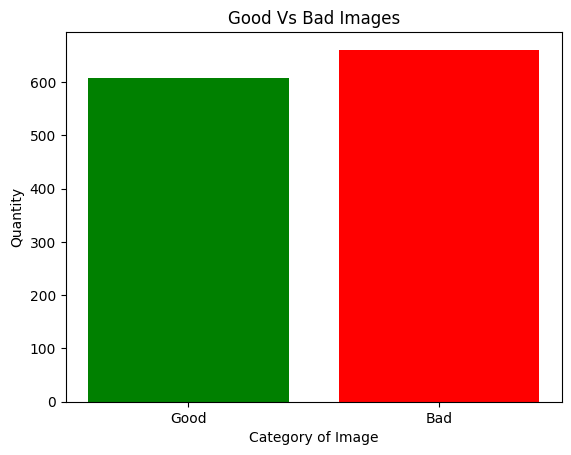

608
661


In [15]:

xcoordinates=[1, 2] #Solo hay dos grupos.
  

height = [count_Good, count_Bad] #Se indica la altura de cada uno
  

tick_label = ['Good', 'Bad'] #Etiquetas de los grupos
  

plt.bar(xcoordinates, height, tick_label = tick_label,
        width = 0.8, color = ['green', 'red']) #Se muestra un grafico de barras con la barra de buenas a color ver y de mala a rojo
  

plt.xlabel('Category of Image') #Nombrar las coodenadas x

plt.ylabel('Quantity') #Nombrar las coodenadas y

plt.title('Good Vs Bad Images') #Nombrar el titulo del grafico
  

plt.show() #Se muestra el grafico
print(count_Good)
print(count_Bad)

# Algoritmo de entreno

In [3]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10, verbose=True):
    
    model.train() #Se pone en estado de entreno

    loss_v = 0

    correct=0
    
    for batch_idx, (data, target,_) in enumerate(train_loader): #Por cada batch en el dataset
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
        loss.backward()
        optimizer.step()
        if verbose:
            if len(data)==20:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
            else:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                    epoch,len(train_loader.dataset)-len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item() #Si se ha predecido bien se suma.
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    accuracy=correct / len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss_v, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    
 
    
    return loss_v,accuracy # Se devuelve la perdida y la precision conseguida


def test(model, device, test_loader):
    model.eval() #Se pone en estado de evaluacion
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target,_ in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += nn.CrossEntropyLoss(reduction='sum')(output, target) 
            
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item() #Se suma si se ha predecido de forma correcta la etiqueta
 
  
    test_loss /= len(test_loader.dataset) #Se calcula la media de la perdida

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    
    accuracy=correct / len(test_loader.dataset)
    return test_loss,accuracy # Se devuelve la perdida y la precision conseguida

# Definicion del modelo

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:

    
def initialize_model2(num_classes):
    #Los pesos si se entrenan
    model_ft = models.inception_v3(weights=False) #Se carga el modelo inception_v3 sin sus pesos preentrenados.
    # False en las redes convencionales, se entrenaran
    set_parameter_requires_grad(model_ft, False)
    # Se modifica la red auxiliar
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

    # Se modifica la red principal para que sea de dos clases con una salida softmax y coger la con mas probabilidad.
    model_ft.dropout= nn.Dropout(0.5)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Dropout(0.3),
        nn.Softmax(dim=1)
    )


    input_size=299 #Tamaño que usa la red
    return model_ft,input_size




# Entreno

# Modelo con Datos Ampliados


In [19]:
model_ftImT,_= initialize_model2(2)
modelImT=model_ftImT.to(device)

model_ftImT.aux_logits=False

params_to_updateImT = model_ftImT.parameters()
print("Params to learn:")
params_to_updateImT = []
for name,param in model_ftImT.named_parameters():
    
    if (param.requires_grad == True) & (not ('AuxLogits' in name)):
        params_to_updateImT.append(param)
        print("\t",name)


print(model_ftImT.fc)


parametrosImT=sum(p.numel() for p in params_to_updateImT)



C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

## Implementación del early stopping


In [57]:
# Datos para el early stopping
datosEntreno = goodBadDataset(img_files,transform1)+goodBadDataset(img_files,transform1)+goodBadDataset(img_files,transform2)+goodBadDataset(img_files,transform3)+goodBadDataset(img_files,transform4) # #Se genera un dataset de entreno con todas las transformaciones expuestas anteriormente a las imagenesy se pasan a tensor.

random_train_idx = np.random.choice(np.array(range(len(datosEntreno))),replace=False, size=datosEntreno.__len__())
train_subset = Subset(datosEntreno, random_train_idx)
dataloaderEntreno=DataLoader(train_subset,batch_size=20,shuffle=True)

# Variables para el seguimiento del early stopping
best_val_loss = float('inf')
patience = 10  # Número de épocas sin mejora antes de detener el entrenamiento
counter = 0

epochs=40
lr=0.001



print("Parameters ",parametrosImT)
optimizerx = optim.Adam(params_to_updateImT, lr=lr)


# Loop de entrenamiento
for epoch in range(epochs):
    # Entrenamiento
    train_loss, train_accuracy = train(modelImT, device, dataloaderEntreno, optimizerx, epoch, verbose=True)
    
    # Evaluación en el conjunto de validación
    val_loss, val_accuracy = test(modelImT, device, val_dl2)
    
    # Verifica si la pérdida de validación ha mejorado
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        counter = 0  # Reinicia el contador de paciencia
        ruta_base = r'..\Pesos\Dataset 2\modeltranformaciones'
        # Convierte el entero a una cadena y concatena todo
        PATH = f"{ruta_base}Epoca{epoch}.pt"      
        torch.save(modelImT.state_dict(), PATH)
    else:
        counter += 1
    
    # Aplica early stopping si se alcanza la paciencia máxima
    if counter >= patience:  # Ajusta el número de épocas de paciencia según tus necesidades
        print(f'Early stopping after epoch {epoch} (Best epoch: {best_epoch}).')
        break

Parameters  21789666
Train Epoch: 0 [0/31725 (0%)]	Loss: 14.389057, Average: 0.719453
Train Epoch: 0 [20/31725 (0%)]	Loss: 13.465974, Average: 0.673299
Train Epoch: 0 [40/31725 (0%)]	Loss: 13.026785, Average: 0.651339
Train Epoch: 0 [60/31725 (0%)]	Loss: 13.793590, Average: 0.689679
Train Epoch: 0 [80/31725 (0%)]	Loss: 9.662561, Average: 0.483128
Train Epoch: 0 [100/31725 (0%)]	Loss: 13.259369, Average: 0.662968
Train Epoch: 0 [120/31725 (0%)]	Loss: 8.522969, Average: 0.426148
Train Epoch: 0 [140/31725 (0%)]	Loss: 12.675425, Average: 0.633771
Train Epoch: 0 [160/31725 (1%)]	Loss: 14.245883, Average: 0.712294
Train Epoch: 0 [180/31725 (1%)]	Loss: 12.149267, Average: 0.607463
Train Epoch: 0 [200/31725 (1%)]	Loss: 12.980696, Average: 0.649035
Train Epoch: 0 [220/31725 (1%)]	Loss: 11.667126, Average: 0.583356
Train Epoch: 0 [240/31725 (1%)]	Loss: 9.877552, Average: 0.493878
Train Epoch: 0 [260/31725 (1%)]	Loss: 10.760118, Average: 0.538006
Train Epoch: 0 [280/31725 (1%)]	Loss: 11.839639, A

Train Epoch: 0 [2440/31725 (8%)]	Loss: 13.147109, Average: 0.657355
Train Epoch: 0 [2460/31725 (8%)]	Loss: 9.757927, Average: 0.487896
Train Epoch: 0 [2480/31725 (8%)]	Loss: 11.438437, Average: 0.571922
Train Epoch: 0 [2500/31725 (8%)]	Loss: 11.221909, Average: 0.561095
Train Epoch: 0 [2520/31725 (8%)]	Loss: 10.556822, Average: 0.527841
Train Epoch: 0 [2540/31725 (8%)]	Loss: 11.420454, Average: 0.571023
Train Epoch: 0 [2560/31725 (8%)]	Loss: 11.204236, Average: 0.560212
Train Epoch: 0 [2580/31725 (8%)]	Loss: 12.656428, Average: 0.632821
Train Epoch: 0 [2600/31725 (8%)]	Loss: 12.234335, Average: 0.611717
Train Epoch: 0 [2620/31725 (8%)]	Loss: 11.367033, Average: 0.568352
Train Epoch: 0 [2640/31725 (8%)]	Loss: 10.960140, Average: 0.548007
Train Epoch: 0 [2660/31725 (8%)]	Loss: 11.324791, Average: 0.566240
Train Epoch: 0 [2680/31725 (8%)]	Loss: 12.840405, Average: 0.642020
Train Epoch: 0 [2700/31725 (9%)]	Loss: 7.726785, Average: 0.386339
Train Epoch: 0 [2720/31725 (9%)]	Loss: 12.228682, 

Train Epoch: 0 [4840/31725 (15%)]	Loss: 11.829198, Average: 0.591460
Train Epoch: 0 [4860/31725 (15%)]	Loss: 10.447840, Average: 0.522392
Train Epoch: 0 [4880/31725 (15%)]	Loss: 12.547460, Average: 0.627373
Train Epoch: 0 [4900/31725 (15%)]	Loss: 11.659807, Average: 0.582990
Train Epoch: 0 [4920/31725 (16%)]	Loss: 12.368821, Average: 0.618441
Train Epoch: 0 [4940/31725 (16%)]	Loss: 14.568872, Average: 0.728444
Train Epoch: 0 [4960/31725 (16%)]	Loss: 9.994981, Average: 0.499749
Train Epoch: 0 [4980/31725 (16%)]	Loss: 11.665492, Average: 0.583275
Train Epoch: 0 [5000/31725 (16%)]	Loss: 12.226033, Average: 0.611302
Train Epoch: 0 [5020/31725 (16%)]	Loss: 13.080971, Average: 0.654049
Train Epoch: 0 [5040/31725 (16%)]	Loss: 8.787878, Average: 0.439394
Train Epoch: 0 [5060/31725 (16%)]	Loss: 11.374768, Average: 0.568738
Train Epoch: 0 [5080/31725 (16%)]	Loss: 13.806409, Average: 0.690320
Train Epoch: 0 [5100/31725 (16%)]	Loss: 13.291786, Average: 0.664589
Train Epoch: 0 [5120/31725 (16%)]	Lo

Train Epoch: 0 [7240/31725 (23%)]	Loss: 10.601617, Average: 0.530081
Train Epoch: 0 [7260/31725 (23%)]	Loss: 13.483781, Average: 0.674189
Train Epoch: 0 [7280/31725 (23%)]	Loss: 10.046686, Average: 0.502334
Train Epoch: 0 [7300/31725 (23%)]	Loss: 8.612980, Average: 0.430649
Train Epoch: 0 [7320/31725 (23%)]	Loss: 9.739040, Average: 0.486952
Train Epoch: 0 [7340/31725 (23%)]	Loss: 9.814228, Average: 0.490711
Train Epoch: 0 [7360/31725 (23%)]	Loss: 13.068531, Average: 0.653427
Train Epoch: 0 [7380/31725 (23%)]	Loss: 8.924342, Average: 0.446217
Train Epoch: 0 [7400/31725 (23%)]	Loss: 13.180502, Average: 0.659025
Train Epoch: 0 [7420/31725 (23%)]	Loss: 11.535403, Average: 0.576770
Train Epoch: 0 [7440/31725 (23%)]	Loss: 8.497151, Average: 0.424858
Train Epoch: 0 [7460/31725 (24%)]	Loss: 12.414940, Average: 0.620747
Train Epoch: 0 [7480/31725 (24%)]	Loss: 9.282788, Average: 0.464139
Train Epoch: 0 [7500/31725 (24%)]	Loss: 10.037512, Average: 0.501876
Train Epoch: 0 [7520/31725 (24%)]	Loss: 

Train Epoch: 0 [9640/31725 (30%)]	Loss: 12.184061, Average: 0.609203
Train Epoch: 0 [9660/31725 (30%)]	Loss: 10.316446, Average: 0.515822
Train Epoch: 0 [9680/31725 (30%)]	Loss: 11.678060, Average: 0.583903
Train Epoch: 0 [9700/31725 (31%)]	Loss: 12.288102, Average: 0.614405
Train Epoch: 0 [9720/31725 (31%)]	Loss: 8.633740, Average: 0.431687
Train Epoch: 0 [9740/31725 (31%)]	Loss: 11.421871, Average: 0.571094
Train Epoch: 0 [9760/31725 (31%)]	Loss: 10.152538, Average: 0.507627
Train Epoch: 0 [9780/31725 (31%)]	Loss: 14.023381, Average: 0.701169
Train Epoch: 0 [9800/31725 (31%)]	Loss: 9.234951, Average: 0.461748
Train Epoch: 0 [9820/31725 (31%)]	Loss: 12.311471, Average: 0.615574
Train Epoch: 0 [9840/31725 (31%)]	Loss: 13.216852, Average: 0.660843
Train Epoch: 0 [9860/31725 (31%)]	Loss: 10.806315, Average: 0.540316
Train Epoch: 0 [9880/31725 (31%)]	Loss: 12.178061, Average: 0.608903
Train Epoch: 0 [9900/31725 (31%)]	Loss: 7.623147, Average: 0.381157
Train Epoch: 0 [9920/31725 (31%)]	Los

Train Epoch: 0 [12000/31725 (38%)]	Loss: 10.585308, Average: 0.529265
Train Epoch: 0 [12020/31725 (38%)]	Loss: 12.457975, Average: 0.622899
Train Epoch: 0 [12040/31725 (38%)]	Loss: 10.780334, Average: 0.539017
Train Epoch: 0 [12060/31725 (38%)]	Loss: 7.487117, Average: 0.374356
Train Epoch: 0 [12080/31725 (38%)]	Loss: 10.665965, Average: 0.533298
Train Epoch: 0 [12100/31725 (38%)]	Loss: 9.204049, Average: 0.460202
Train Epoch: 0 [12120/31725 (38%)]	Loss: 9.203773, Average: 0.460189
Train Epoch: 0 [12140/31725 (38%)]	Loss: 11.768578, Average: 0.588429
Train Epoch: 0 [12160/31725 (38%)]	Loss: 7.665711, Average: 0.383286
Train Epoch: 0 [12180/31725 (38%)]	Loss: 12.349705, Average: 0.617485
Train Epoch: 0 [12200/31725 (38%)]	Loss: 8.699821, Average: 0.434991
Train Epoch: 0 [12220/31725 (39%)]	Loss: 7.661913, Average: 0.383096
Train Epoch: 0 [12240/31725 (39%)]	Loss: 11.216372, Average: 0.560819
Train Epoch: 0 [12260/31725 (39%)]	Loss: 10.936311, Average: 0.546816
Train Epoch: 0 [12280/3172

Train Epoch: 0 [14360/31725 (45%)]	Loss: 9.716413, Average: 0.485821
Train Epoch: 0 [14380/31725 (45%)]	Loss: 11.318580, Average: 0.565929
Train Epoch: 0 [14400/31725 (45%)]	Loss: 9.523193, Average: 0.476160
Train Epoch: 0 [14420/31725 (45%)]	Loss: 12.200513, Average: 0.610026
Train Epoch: 0 [14440/31725 (45%)]	Loss: 12.105337, Average: 0.605267
Train Epoch: 0 [14460/31725 (46%)]	Loss: 11.484797, Average: 0.574240
Train Epoch: 0 [14480/31725 (46%)]	Loss: 7.405912, Average: 0.370296
Train Epoch: 0 [14500/31725 (46%)]	Loss: 10.990346, Average: 0.549517
Train Epoch: 0 [14520/31725 (46%)]	Loss: 11.864841, Average: 0.593242
Train Epoch: 0 [14540/31725 (46%)]	Loss: 9.691270, Average: 0.484563
Train Epoch: 0 [14560/31725 (46%)]	Loss: 9.496418, Average: 0.474821
Train Epoch: 0 [14580/31725 (46%)]	Loss: 12.156406, Average: 0.607820
Train Epoch: 0 [14600/31725 (46%)]	Loss: 9.225535, Average: 0.461277
Train Epoch: 0 [14620/31725 (46%)]	Loss: 9.853470, Average: 0.492673
Train Epoch: 0 [14640/31725

Train Epoch: 0 [16720/31725 (53%)]	Loss: 9.682896, Average: 0.484145
Train Epoch: 0 [16740/31725 (53%)]	Loss: 10.563852, Average: 0.528193
Train Epoch: 0 [16760/31725 (53%)]	Loss: 12.398055, Average: 0.619903
Train Epoch: 0 [16780/31725 (53%)]	Loss: 14.276994, Average: 0.713850
Train Epoch: 0 [16800/31725 (53%)]	Loss: 10.960639, Average: 0.548032
Train Epoch: 0 [16820/31725 (53%)]	Loss: 8.826151, Average: 0.441308
Train Epoch: 0 [16840/31725 (53%)]	Loss: 11.076285, Average: 0.553814
Train Epoch: 0 [16860/31725 (53%)]	Loss: 9.210045, Average: 0.460502
Train Epoch: 0 [16880/31725 (53%)]	Loss: 9.214007, Average: 0.460700
Train Epoch: 0 [16900/31725 (53%)]	Loss: 9.266531, Average: 0.463327
Train Epoch: 0 [16920/31725 (53%)]	Loss: 8.365421, Average: 0.418271
Train Epoch: 0 [16940/31725 (53%)]	Loss: 11.625906, Average: 0.581295
Train Epoch: 0 [16960/31725 (53%)]	Loss: 12.701134, Average: 0.635057
Train Epoch: 0 [16980/31725 (53%)]	Loss: 11.955188, Average: 0.597759
Train Epoch: 0 [17000/3172

Train Epoch: 0 [19080/31725 (60%)]	Loss: 10.361517, Average: 0.518076
Train Epoch: 0 [19100/31725 (60%)]	Loss: 11.326728, Average: 0.566336
Train Epoch: 0 [19120/31725 (60%)]	Loss: 9.736814, Average: 0.486841
Train Epoch: 0 [19140/31725 (60%)]	Loss: 9.194966, Average: 0.459748
Train Epoch: 0 [19160/31725 (60%)]	Loss: 12.735714, Average: 0.636786
Train Epoch: 0 [19180/31725 (60%)]	Loss: 13.580803, Average: 0.679040
Train Epoch: 0 [19200/31725 (60%)]	Loss: 10.861051, Average: 0.543053
Train Epoch: 0 [19220/31725 (61%)]	Loss: 8.934910, Average: 0.446745
Train Epoch: 0 [19240/31725 (61%)]	Loss: 12.203953, Average: 0.610198
Train Epoch: 0 [19260/31725 (61%)]	Loss: 10.103222, Average: 0.505161
Train Epoch: 0 [19280/31725 (61%)]	Loss: 9.529346, Average: 0.476467
Train Epoch: 0 [19300/31725 (61%)]	Loss: 11.765969, Average: 0.588298
Train Epoch: 0 [19320/31725 (61%)]	Loss: 10.386109, Average: 0.519305
Train Epoch: 0 [19340/31725 (61%)]	Loss: 10.467697, Average: 0.523385
Train Epoch: 0 [19360/31

Train Epoch: 0 [21440/31725 (68%)]	Loss: 8.223328, Average: 0.411166
Train Epoch: 0 [21460/31725 (68%)]	Loss: 9.935802, Average: 0.496790
Train Epoch: 0 [21480/31725 (68%)]	Loss: 7.687719, Average: 0.384386
Train Epoch: 0 [21500/31725 (68%)]	Loss: 9.783870, Average: 0.489193
Train Epoch: 0 [21520/31725 (68%)]	Loss: 9.113659, Average: 0.455683
Train Epoch: 0 [21540/31725 (68%)]	Loss: 8.613734, Average: 0.430687
Train Epoch: 0 [21560/31725 (68%)]	Loss: 11.166700, Average: 0.558335
Train Epoch: 0 [21580/31725 (68%)]	Loss: 10.351528, Average: 0.517576
Train Epoch: 0 [21600/31725 (68%)]	Loss: 12.549372, Average: 0.627469
Train Epoch: 0 [21620/31725 (68%)]	Loss: 14.688450, Average: 0.734422
Train Epoch: 0 [21640/31725 (68%)]	Loss: 12.167455, Average: 0.608373
Train Epoch: 0 [21660/31725 (68%)]	Loss: 10.271775, Average: 0.513589
Train Epoch: 0 [21680/31725 (68%)]	Loss: 10.866674, Average: 0.543334
Train Epoch: 0 [21700/31725 (68%)]	Loss: 10.876633, Average: 0.543832
Train Epoch: 0 [21720/3172

Train Epoch: 0 [23800/31725 (75%)]	Loss: 11.365613, Average: 0.568281
Train Epoch: 0 [23820/31725 (75%)]	Loss: 10.104047, Average: 0.505202
Train Epoch: 0 [23840/31725 (75%)]	Loss: 8.583345, Average: 0.429167
Train Epoch: 0 [23860/31725 (75%)]	Loss: 10.811014, Average: 0.540551
Train Epoch: 0 [23880/31725 (75%)]	Loss: 10.123556, Average: 0.506178
Train Epoch: 0 [23900/31725 (75%)]	Loss: 9.322579, Average: 0.466129
Train Epoch: 0 [23920/31725 (75%)]	Loss: 8.251513, Average: 0.412576
Train Epoch: 0 [23940/31725 (75%)]	Loss: 12.918463, Average: 0.645923
Train Epoch: 0 [23960/31725 (75%)]	Loss: 8.192939, Average: 0.409647
Train Epoch: 0 [23980/31725 (76%)]	Loss: 10.863792, Average: 0.543190
Train Epoch: 0 [24000/31725 (76%)]	Loss: 11.471405, Average: 0.573570
Train Epoch: 0 [24020/31725 (76%)]	Loss: 9.697042, Average: 0.484852
Train Epoch: 0 [24040/31725 (76%)]	Loss: 11.815060, Average: 0.590753
Train Epoch: 0 [24060/31725 (76%)]	Loss: 11.450578, Average: 0.572529
Train Epoch: 0 [24080/317

Train Epoch: 0 [26160/31725 (82%)]	Loss: 9.730310, Average: 0.486516
Train Epoch: 0 [26180/31725 (82%)]	Loss: 9.231308, Average: 0.461565
Train Epoch: 0 [26200/31725 (83%)]	Loss: 11.024051, Average: 0.551203
Train Epoch: 0 [26220/31725 (83%)]	Loss: 8.955235, Average: 0.447762
Train Epoch: 0 [26240/31725 (83%)]	Loss: 10.613829, Average: 0.530691
Train Epoch: 0 [26260/31725 (83%)]	Loss: 9.945203, Average: 0.497260
Train Epoch: 0 [26280/31725 (83%)]	Loss: 7.959820, Average: 0.397991
Train Epoch: 0 [26300/31725 (83%)]	Loss: 9.839122, Average: 0.491956
Train Epoch: 0 [26320/31725 (83%)]	Loss: 10.040900, Average: 0.502045
Train Epoch: 0 [26340/31725 (83%)]	Loss: 9.689132, Average: 0.484457
Train Epoch: 0 [26360/31725 (83%)]	Loss: 12.507230, Average: 0.625361
Train Epoch: 0 [26380/31725 (83%)]	Loss: 8.338226, Average: 0.416911
Train Epoch: 0 [26400/31725 (83%)]	Loss: 9.794557, Average: 0.489728
Train Epoch: 0 [26420/31725 (83%)]	Loss: 9.518692, Average: 0.475935
Train Epoch: 0 [26440/31725 (8

Train Epoch: 0 [28520/31725 (90%)]	Loss: 10.318109, Average: 0.515905
Train Epoch: 0 [28540/31725 (90%)]	Loss: 9.303785, Average: 0.465189
Train Epoch: 0 [28560/31725 (90%)]	Loss: 10.259182, Average: 0.512959
Train Epoch: 0 [28580/31725 (90%)]	Loss: 9.022795, Average: 0.451140
Train Epoch: 0 [28600/31725 (90%)]	Loss: 10.970771, Average: 0.548539
Train Epoch: 0 [28620/31725 (90%)]	Loss: 7.899858, Average: 0.394993
Train Epoch: 0 [28640/31725 (90%)]	Loss: 9.091535, Average: 0.454577
Train Epoch: 0 [28660/31725 (90%)]	Loss: 9.770587, Average: 0.488529
Train Epoch: 0 [28680/31725 (90%)]	Loss: 11.788265, Average: 0.589413
Train Epoch: 0 [28700/31725 (90%)]	Loss: 13.287325, Average: 0.664366
Train Epoch: 0 [28720/31725 (90%)]	Loss: 9.815945, Average: 0.490797
Train Epoch: 0 [28740/31725 (91%)]	Loss: 13.857391, Average: 0.692870
Train Epoch: 0 [28760/31725 (91%)]	Loss: 11.869851, Average: 0.593493
Train Epoch: 0 [28780/31725 (91%)]	Loss: 10.443643, Average: 0.522182
Train Epoch: 0 [28800/3172

Train Epoch: 0 [30900/31725 (97%)]	Loss: 12.357960, Average: 0.617898
Train Epoch: 0 [30920/31725 (97%)]	Loss: 8.571268, Average: 0.428563
Train Epoch: 0 [30940/31725 (97%)]	Loss: 11.766888, Average: 0.588344
Train Epoch: 0 [30960/31725 (98%)]	Loss: 9.854767, Average: 0.492738
Train Epoch: 0 [30980/31725 (98%)]	Loss: 8.149127, Average: 0.407456
Train Epoch: 0 [31000/31725 (98%)]	Loss: 11.626096, Average: 0.581305
Train Epoch: 0 [31020/31725 (98%)]	Loss: 9.717097, Average: 0.485855
Train Epoch: 0 [31040/31725 (98%)]	Loss: 11.048709, Average: 0.552435
Train Epoch: 0 [31060/31725 (98%)]	Loss: 11.667413, Average: 0.583371
Train Epoch: 0 [31080/31725 (98%)]	Loss: 9.592937, Average: 0.479647
Train Epoch: 0 [31100/31725 (98%)]	Loss: 10.228274, Average: 0.511414
Train Epoch: 0 [31120/31725 (98%)]	Loss: 7.997448, Average: 0.399872
Train Epoch: 0 [31140/31725 (98%)]	Loss: 10.529792, Average: 0.526490
Train Epoch: 0 [31160/31725 (98%)]	Loss: 9.698128, Average: 0.484906
Train Epoch: 0 [31180/31725

Train Epoch: 1 [1560/31725 (5%)]	Loss: 8.265961, Average: 0.413298
Train Epoch: 1 [1580/31725 (5%)]	Loss: 8.289244, Average: 0.414462
Train Epoch: 1 [1600/31725 (5%)]	Loss: 10.801016, Average: 0.540051
Train Epoch: 1 [1620/31725 (5%)]	Loss: 10.052855, Average: 0.502643
Train Epoch: 1 [1640/31725 (5%)]	Loss: 12.113884, Average: 0.605694
Train Epoch: 1 [1660/31725 (5%)]	Loss: 13.820042, Average: 0.691002
Train Epoch: 1 [1680/31725 (5%)]	Loss: 11.336495, Average: 0.566825
Train Epoch: 1 [1700/31725 (5%)]	Loss: 10.921428, Average: 0.546071
Train Epoch: 1 [1720/31725 (5%)]	Loss: 12.175981, Average: 0.608799
Train Epoch: 1 [1740/31725 (5%)]	Loss: 9.526703, Average: 0.476335
Train Epoch: 1 [1760/31725 (6%)]	Loss: 10.971119, Average: 0.548556
Train Epoch: 1 [1780/31725 (6%)]	Loss: 8.524262, Average: 0.426213
Train Epoch: 1 [1800/31725 (6%)]	Loss: 10.536812, Average: 0.526841
Train Epoch: 1 [1820/31725 (6%)]	Loss: 10.926578, Average: 0.546329
Train Epoch: 1 [1840/31725 (6%)]	Loss: 8.829871, Ave

Train Epoch: 1 [3980/31725 (13%)]	Loss: 10.941702, Average: 0.547085
Train Epoch: 1 [4000/31725 (13%)]	Loss: 8.202975, Average: 0.410149
Train Epoch: 1 [4020/31725 (13%)]	Loss: 9.381699, Average: 0.469085
Train Epoch: 1 [4040/31725 (13%)]	Loss: 7.696602, Average: 0.384830
Train Epoch: 1 [4060/31725 (13%)]	Loss: 10.036223, Average: 0.501811
Train Epoch: 1 [4080/31725 (13%)]	Loss: 7.976298, Average: 0.398815
Train Epoch: 1 [4100/31725 (13%)]	Loss: 10.168130, Average: 0.508406
Train Epoch: 1 [4120/31725 (13%)]	Loss: 10.375616, Average: 0.518781
Train Epoch: 1 [4140/31725 (13%)]	Loss: 11.495790, Average: 0.574789
Train Epoch: 1 [4160/31725 (13%)]	Loss: 8.257139, Average: 0.412857
Train Epoch: 1 [4180/31725 (13%)]	Loss: 9.039763, Average: 0.451988
Train Epoch: 1 [4200/31725 (13%)]	Loss: 10.967083, Average: 0.548354
Train Epoch: 1 [4220/31725 (13%)]	Loss: 9.399213, Average: 0.469961
Train Epoch: 1 [4240/31725 (13%)]	Loss: 11.090934, Average: 0.554547
Train Epoch: 1 [4260/31725 (13%)]	Loss: 8

Train Epoch: 1 [6380/31725 (20%)]	Loss: 9.535818, Average: 0.476791
Train Epoch: 1 [6400/31725 (20%)]	Loss: 10.335703, Average: 0.516785
Train Epoch: 1 [6420/31725 (20%)]	Loss: 11.203380, Average: 0.560169
Train Epoch: 1 [6440/31725 (20%)]	Loss: 11.262731, Average: 0.563137
Train Epoch: 1 [6460/31725 (20%)]	Loss: 8.972288, Average: 0.448614
Train Epoch: 1 [6480/31725 (20%)]	Loss: 9.248428, Average: 0.462421
Train Epoch: 1 [6500/31725 (20%)]	Loss: 8.887880, Average: 0.444394
Train Epoch: 1 [6520/31725 (21%)]	Loss: 9.624713, Average: 0.481236
Train Epoch: 1 [6540/31725 (21%)]	Loss: 11.023952, Average: 0.551198
Train Epoch: 1 [6560/31725 (21%)]	Loss: 8.625271, Average: 0.431264
Train Epoch: 1 [6580/31725 (21%)]	Loss: 12.786439, Average: 0.639322
Train Epoch: 1 [6600/31725 (21%)]	Loss: 8.961226, Average: 0.448061
Train Epoch: 1 [6620/31725 (21%)]	Loss: 7.414462, Average: 0.370723
Train Epoch: 1 [6640/31725 (21%)]	Loss: 10.547276, Average: 0.527364
Train Epoch: 1 [6660/31725 (21%)]	Loss: 10

Train Epoch: 1 [8780/31725 (28%)]	Loss: 8.896120, Average: 0.444806
Train Epoch: 1 [8800/31725 (28%)]	Loss: 10.752061, Average: 0.537603
Train Epoch: 1 [8820/31725 (28%)]	Loss: 10.595291, Average: 0.529765
Train Epoch: 1 [8840/31725 (28%)]	Loss: 9.437647, Average: 0.471882
Train Epoch: 1 [8860/31725 (28%)]	Loss: 13.127377, Average: 0.656369
Train Epoch: 1 [8880/31725 (28%)]	Loss: 8.917002, Average: 0.445850
Train Epoch: 1 [8900/31725 (28%)]	Loss: 11.374317, Average: 0.568716
Train Epoch: 1 [8920/31725 (28%)]	Loss: 8.508712, Average: 0.425436
Train Epoch: 1 [8940/31725 (28%)]	Loss: 10.753552, Average: 0.537678
Train Epoch: 1 [8960/31725 (28%)]	Loss: 9.660269, Average: 0.483013
Train Epoch: 1 [8980/31725 (28%)]	Loss: 8.235217, Average: 0.411761
Train Epoch: 1 [9000/31725 (28%)]	Loss: 9.802786, Average: 0.490139
Train Epoch: 1 [9020/31725 (28%)]	Loss: 10.510990, Average: 0.525550
Train Epoch: 1 [9040/31725 (28%)]	Loss: 10.026990, Average: 0.501349
Train Epoch: 1 [9060/31725 (29%)]	Loss: 1

Train Epoch: 1 [11160/31725 (35%)]	Loss: 7.674299, Average: 0.383715
Train Epoch: 1 [11180/31725 (35%)]	Loss: 9.176126, Average: 0.458806
Train Epoch: 1 [11200/31725 (35%)]	Loss: 8.020306, Average: 0.401015
Train Epoch: 1 [11220/31725 (35%)]	Loss: 7.287270, Average: 0.364363
Train Epoch: 1 [11240/31725 (35%)]	Loss: 10.022206, Average: 0.501110
Train Epoch: 1 [11260/31725 (35%)]	Loss: 9.355302, Average: 0.467765
Train Epoch: 1 [11280/31725 (36%)]	Loss: 10.373023, Average: 0.518651
Train Epoch: 1 [11300/31725 (36%)]	Loss: 10.886135, Average: 0.544307
Train Epoch: 1 [11320/31725 (36%)]	Loss: 8.728185, Average: 0.436409
Train Epoch: 1 [11340/31725 (36%)]	Loss: 12.056345, Average: 0.602817
Train Epoch: 1 [11360/31725 (36%)]	Loss: 9.179397, Average: 0.458970
Train Epoch: 1 [11380/31725 (36%)]	Loss: 12.879524, Average: 0.643976
Train Epoch: 1 [11400/31725 (36%)]	Loss: 7.888888, Average: 0.394444
Train Epoch: 1 [11420/31725 (36%)]	Loss: 8.869600, Average: 0.443480
Train Epoch: 1 [11440/31725 (

Train Epoch: 1 [13540/31725 (43%)]	Loss: 9.405038, Average: 0.470252
Train Epoch: 1 [13560/31725 (43%)]	Loss: 9.758147, Average: 0.487907
Train Epoch: 1 [13580/31725 (43%)]	Loss: 6.768158, Average: 0.338408
Train Epoch: 1 [13600/31725 (43%)]	Loss: 11.407299, Average: 0.570365
Train Epoch: 1 [13620/31725 (43%)]	Loss: 6.872786, Average: 0.343639
Train Epoch: 1 [13640/31725 (43%)]	Loss: 9.415638, Average: 0.470782
Train Epoch: 1 [13660/31725 (43%)]	Loss: 9.784293, Average: 0.489215
Train Epoch: 1 [13680/31725 (43%)]	Loss: 8.498777, Average: 0.424939
Train Epoch: 1 [13700/31725 (43%)]	Loss: 8.453044, Average: 0.422652
Train Epoch: 1 [13720/31725 (43%)]	Loss: 8.743996, Average: 0.437200
Train Epoch: 1 [13740/31725 (43%)]	Loss: 8.156244, Average: 0.407812
Train Epoch: 1 [13760/31725 (43%)]	Loss: 8.959773, Average: 0.447989
Train Epoch: 1 [13780/31725 (43%)]	Loss: 9.436172, Average: 0.471809
Train Epoch: 1 [13800/31725 (43%)]	Loss: 10.345018, Average: 0.517251
Train Epoch: 1 [13820/31725 (44%

Train Epoch: 1 [15920/31725 (50%)]	Loss: 12.329361, Average: 0.616468
Train Epoch: 1 [15940/31725 (50%)]	Loss: 9.767657, Average: 0.488383
Train Epoch: 1 [15960/31725 (50%)]	Loss: 7.699076, Average: 0.384954
Train Epoch: 1 [15980/31725 (50%)]	Loss: 8.728851, Average: 0.436443
Train Epoch: 1 [16000/31725 (50%)]	Loss: 9.278808, Average: 0.463940
Train Epoch: 1 [16020/31725 (50%)]	Loss: 9.899570, Average: 0.494979
Train Epoch: 1 [16040/31725 (51%)]	Loss: 7.561624, Average: 0.378081
Train Epoch: 1 [16060/31725 (51%)]	Loss: 8.761699, Average: 0.438085
Train Epoch: 1 [16080/31725 (51%)]	Loss: 11.834750, Average: 0.591738
Train Epoch: 1 [16100/31725 (51%)]	Loss: 8.198595, Average: 0.409930
Train Epoch: 1 [16120/31725 (51%)]	Loss: 8.137225, Average: 0.406861
Train Epoch: 1 [16140/31725 (51%)]	Loss: 8.409051, Average: 0.420453
Train Epoch: 1 [16160/31725 (51%)]	Loss: 10.663696, Average: 0.533185
Train Epoch: 1 [16180/31725 (51%)]	Loss: 10.970422, Average: 0.548521
Train Epoch: 1 [16200/31725 (5

Train Epoch: 1 [18280/31725 (58%)]	Loss: 8.288768, Average: 0.414438
Train Epoch: 1 [18300/31725 (58%)]	Loss: 9.281108, Average: 0.464055
Train Epoch: 1 [18320/31725 (58%)]	Loss: 12.543663, Average: 0.627183
Train Epoch: 1 [18340/31725 (58%)]	Loss: 12.818598, Average: 0.640930
Train Epoch: 1 [18360/31725 (58%)]	Loss: 8.630907, Average: 0.431545
Train Epoch: 1 [18380/31725 (58%)]	Loss: 9.623039, Average: 0.481152
Train Epoch: 1 [18400/31725 (58%)]	Loss: 9.802225, Average: 0.490111
Train Epoch: 1 [18420/31725 (58%)]	Loss: 9.594571, Average: 0.479729
Train Epoch: 1 [18440/31725 (58%)]	Loss: 8.295344, Average: 0.414767
Train Epoch: 1 [18460/31725 (58%)]	Loss: 11.743627, Average: 0.587181
Train Epoch: 1 [18480/31725 (58%)]	Loss: 10.803490, Average: 0.540174
Train Epoch: 1 [18500/31725 (58%)]	Loss: 10.115111, Average: 0.505756
Train Epoch: 1 [18520/31725 (58%)]	Loss: 8.682788, Average: 0.434139
Train Epoch: 1 [18540/31725 (58%)]	Loss: 9.165043, Average: 0.458252
Train Epoch: 1 [18560/31725 (

Train Epoch: 1 [20640/31725 (65%)]	Loss: 12.219667, Average: 0.610983
Train Epoch: 1 [20660/31725 (65%)]	Loss: 9.647754, Average: 0.482388
Train Epoch: 1 [20680/31725 (65%)]	Loss: 12.539920, Average: 0.626996
Train Epoch: 1 [20700/31725 (65%)]	Loss: 9.384883, Average: 0.469244
Train Epoch: 1 [20720/31725 (65%)]	Loss: 9.139897, Average: 0.456995
Train Epoch: 1 [20740/31725 (65%)]	Loss: 10.170627, Average: 0.508531
Train Epoch: 1 [20760/31725 (65%)]	Loss: 9.675999, Average: 0.483800
Train Epoch: 1 [20780/31725 (65%)]	Loss: 10.729828, Average: 0.536491
Train Epoch: 1 [20800/31725 (66%)]	Loss: 10.811751, Average: 0.540588
Train Epoch: 1 [20820/31725 (66%)]	Loss: 9.925186, Average: 0.496259
Train Epoch: 1 [20840/31725 (66%)]	Loss: 8.759989, Average: 0.437999
Train Epoch: 1 [20860/31725 (66%)]	Loss: 8.044728, Average: 0.402236
Train Epoch: 1 [20880/31725 (66%)]	Loss: 11.391544, Average: 0.569577
Train Epoch: 1 [20900/31725 (66%)]	Loss: 9.434535, Average: 0.471727
Train Epoch: 1 [20920/31725 

Train Epoch: 1 [23000/31725 (72%)]	Loss: 13.253048, Average: 0.662652
Train Epoch: 1 [23020/31725 (73%)]	Loss: 8.814366, Average: 0.440718
Train Epoch: 1 [23040/31725 (73%)]	Loss: 11.994022, Average: 0.599701
Train Epoch: 1 [23060/31725 (73%)]	Loss: 13.035751, Average: 0.651788
Train Epoch: 1 [23080/31725 (73%)]	Loss: 10.401593, Average: 0.520080
Train Epoch: 1 [23100/31725 (73%)]	Loss: 9.805923, Average: 0.490296
Train Epoch: 1 [23120/31725 (73%)]	Loss: 10.258008, Average: 0.512900
Train Epoch: 1 [23140/31725 (73%)]	Loss: 7.716198, Average: 0.385810
Train Epoch: 1 [23160/31725 (73%)]	Loss: 8.820724, Average: 0.441036
Train Epoch: 1 [23180/31725 (73%)]	Loss: 13.198662, Average: 0.659933
Train Epoch: 1 [23200/31725 (73%)]	Loss: 9.107875, Average: 0.455394
Train Epoch: 1 [23220/31725 (73%)]	Loss: 9.806990, Average: 0.490349
Train Epoch: 1 [23240/31725 (73%)]	Loss: 10.793643, Average: 0.539682
Train Epoch: 1 [23260/31725 (73%)]	Loss: 12.752782, Average: 0.637639
Train Epoch: 1 [23280/3172

Train Epoch: 1 [25360/31725 (80%)]	Loss: 7.908135, Average: 0.395407
Train Epoch: 1 [25380/31725 (80%)]	Loss: 10.394284, Average: 0.519714
Train Epoch: 1 [25400/31725 (80%)]	Loss: 8.221269, Average: 0.411063
Train Epoch: 1 [25420/31725 (80%)]	Loss: 8.990171, Average: 0.449509
Train Epoch: 1 [25440/31725 (80%)]	Loss: 8.492237, Average: 0.424612
Train Epoch: 1 [25460/31725 (80%)]	Loss: 10.639207, Average: 0.531960
Train Epoch: 1 [25480/31725 (80%)]	Loss: 7.716932, Average: 0.385847
Train Epoch: 1 [25500/31725 (80%)]	Loss: 12.940168, Average: 0.647008
Train Epoch: 1 [25520/31725 (80%)]	Loss: 10.011432, Average: 0.500572
Train Epoch: 1 [25540/31725 (80%)]	Loss: 10.236773, Average: 0.511839
Train Epoch: 1 [25560/31725 (81%)]	Loss: 12.044454, Average: 0.602223
Train Epoch: 1 [25580/31725 (81%)]	Loss: 13.914063, Average: 0.695703
Train Epoch: 1 [25600/31725 (81%)]	Loss: 9.071480, Average: 0.453574
Train Epoch: 1 [25620/31725 (81%)]	Loss: 7.944072, Average: 0.397204
Train Epoch: 1 [25640/31725

Train Epoch: 1 [27720/31725 (87%)]	Loss: 10.284082, Average: 0.514204
Train Epoch: 1 [27740/31725 (87%)]	Loss: 11.783672, Average: 0.589184
Train Epoch: 1 [27760/31725 (87%)]	Loss: 9.051243, Average: 0.452562
Train Epoch: 1 [27780/31725 (88%)]	Loss: 8.093829, Average: 0.404691
Train Epoch: 1 [27800/31725 (88%)]	Loss: 9.255205, Average: 0.462760
Train Epoch: 1 [27820/31725 (88%)]	Loss: 10.545682, Average: 0.527284
Train Epoch: 1 [27840/31725 (88%)]	Loss: 8.250340, Average: 0.412517
Train Epoch: 1 [27860/31725 (88%)]	Loss: 10.110529, Average: 0.505526
Train Epoch: 1 [27880/31725 (88%)]	Loss: 10.943854, Average: 0.547193
Train Epoch: 1 [27900/31725 (88%)]	Loss: 10.640036, Average: 0.532002
Train Epoch: 1 [27920/31725 (88%)]	Loss: 9.334803, Average: 0.466740
Train Epoch: 1 [27940/31725 (88%)]	Loss: 12.171290, Average: 0.608565
Train Epoch: 1 [27960/31725 (88%)]	Loss: 8.705362, Average: 0.435268
Train Epoch: 1 [27980/31725 (88%)]	Loss: 8.858582, Average: 0.442929
Train Epoch: 1 [28000/31725

Train Epoch: 1 [30080/31725 (95%)]	Loss: 11.685742, Average: 0.584287
Train Epoch: 1 [30100/31725 (95%)]	Loss: 8.471032, Average: 0.423552
Train Epoch: 1 [30120/31725 (95%)]	Loss: 9.170582, Average: 0.458529
Train Epoch: 1 [30140/31725 (95%)]	Loss: 9.818924, Average: 0.490946
Train Epoch: 1 [30160/31725 (95%)]	Loss: 10.093460, Average: 0.504673
Train Epoch: 1 [30180/31725 (95%)]	Loss: 9.326194, Average: 0.466310
Train Epoch: 1 [30200/31725 (95%)]	Loss: 11.026438, Average: 0.551322
Train Epoch: 1 [30220/31725 (95%)]	Loss: 7.738865, Average: 0.386943
Train Epoch: 1 [30240/31725 (95%)]	Loss: 10.778098, Average: 0.538905
Train Epoch: 1 [30260/31725 (95%)]	Loss: 7.437734, Average: 0.371887
Train Epoch: 1 [30280/31725 (95%)]	Loss: 10.673658, Average: 0.533683
Train Epoch: 1 [30300/31725 (95%)]	Loss: 10.072342, Average: 0.503617
Train Epoch: 1 [30320/31725 (96%)]	Loss: 10.116275, Average: 0.505814
Train Epoch: 1 [30340/31725 (96%)]	Loss: 11.357795, Average: 0.567890
Train Epoch: 1 [30360/3172

Train Epoch: 2 [700/31725 (2%)]	Loss: 8.055943, Average: 0.402797
Train Epoch: 2 [720/31725 (2%)]	Loss: 11.097531, Average: 0.554877
Train Epoch: 2 [740/31725 (2%)]	Loss: 9.196059, Average: 0.459803
Train Epoch: 2 [760/31725 (2%)]	Loss: 11.558096, Average: 0.577905
Train Epoch: 2 [780/31725 (2%)]	Loss: 10.522129, Average: 0.526106
Train Epoch: 2 [800/31725 (3%)]	Loss: 11.256169, Average: 0.562808
Train Epoch: 2 [820/31725 (3%)]	Loss: 11.340158, Average: 0.567008
Train Epoch: 2 [840/31725 (3%)]	Loss: 11.825398, Average: 0.591270
Train Epoch: 2 [860/31725 (3%)]	Loss: 12.827827, Average: 0.641391
Train Epoch: 2 [880/31725 (3%)]	Loss: 11.687699, Average: 0.584385
Train Epoch: 2 [900/31725 (3%)]	Loss: 9.913774, Average: 0.495689
Train Epoch: 2 [920/31725 (3%)]	Loss: 8.696202, Average: 0.434810
Train Epoch: 2 [940/31725 (3%)]	Loss: 7.556388, Average: 0.377819
Train Epoch: 2 [960/31725 (3%)]	Loss: 7.666978, Average: 0.383349
Train Epoch: 2 [980/31725 (3%)]	Loss: 10.778250, Average: 0.538912
T

Train Epoch: 2 [3140/31725 (10%)]	Loss: 7.671558, Average: 0.383578
Train Epoch: 2 [3160/31725 (10%)]	Loss: 9.546370, Average: 0.477318
Train Epoch: 2 [3180/31725 (10%)]	Loss: 9.461999, Average: 0.473100
Train Epoch: 2 [3200/31725 (10%)]	Loss: 7.045081, Average: 0.352254
Train Epoch: 2 [3220/31725 (10%)]	Loss: 8.332158, Average: 0.416608
Train Epoch: 2 [3240/31725 (10%)]	Loss: 7.229859, Average: 0.361493
Train Epoch: 2 [3260/31725 (10%)]	Loss: 11.004304, Average: 0.550215
Train Epoch: 2 [3280/31725 (10%)]	Loss: 10.199753, Average: 0.509988
Train Epoch: 2 [3300/31725 (10%)]	Loss: 14.131021, Average: 0.706551
Train Epoch: 2 [3320/31725 (10%)]	Loss: 9.973612, Average: 0.498681
Train Epoch: 2 [3340/31725 (11%)]	Loss: 7.097179, Average: 0.354859
Train Epoch: 2 [3360/31725 (11%)]	Loss: 8.991373, Average: 0.449569
Train Epoch: 2 [3380/31725 (11%)]	Loss: 8.138409, Average: 0.406920
Train Epoch: 2 [3400/31725 (11%)]	Loss: 10.086794, Average: 0.504340
Train Epoch: 2 [3420/31725 (11%)]	Loss: 8.54

Train Epoch: 2 [5540/31725 (17%)]	Loss: 14.077639, Average: 0.703882
Train Epoch: 2 [5560/31725 (18%)]	Loss: 11.286938, Average: 0.564347
Train Epoch: 2 [5580/31725 (18%)]	Loss: 9.207173, Average: 0.460359
Train Epoch: 2 [5600/31725 (18%)]	Loss: 12.513276, Average: 0.625664
Train Epoch: 2 [5620/31725 (18%)]	Loss: 8.260335, Average: 0.413017
Train Epoch: 2 [5640/31725 (18%)]	Loss: 9.039909, Average: 0.451995
Train Epoch: 2 [5660/31725 (18%)]	Loss: 11.063091, Average: 0.553155
Train Epoch: 2 [5680/31725 (18%)]	Loss: 8.405245, Average: 0.420262
Train Epoch: 2 [5700/31725 (18%)]	Loss: 10.418725, Average: 0.520936
Train Epoch: 2 [5720/31725 (18%)]	Loss: 12.329416, Average: 0.616471
Train Epoch: 2 [5740/31725 (18%)]	Loss: 8.065401, Average: 0.403270
Train Epoch: 2 [5760/31725 (18%)]	Loss: 10.390124, Average: 0.519506
Train Epoch: 2 [5780/31725 (18%)]	Loss: 7.645162, Average: 0.382258
Train Epoch: 2 [5800/31725 (18%)]	Loss: 8.766536, Average: 0.438327
Train Epoch: 2 [5820/31725 (18%)]	Loss: 9

Train Epoch: 2 [7940/31725 (25%)]	Loss: 7.192516, Average: 0.359626
Train Epoch: 2 [7960/31725 (25%)]	Loss: 10.248971, Average: 0.512449
Train Epoch: 2 [7980/31725 (25%)]	Loss: 9.426705, Average: 0.471335
Train Epoch: 2 [8000/31725 (25%)]	Loss: 7.955361, Average: 0.397768
Train Epoch: 2 [8020/31725 (25%)]	Loss: 10.048970, Average: 0.502449
Train Epoch: 2 [8040/31725 (25%)]	Loss: 9.275771, Average: 0.463789
Train Epoch: 2 [8060/31725 (25%)]	Loss: 8.691345, Average: 0.434567
Train Epoch: 2 [8080/31725 (25%)]	Loss: 9.962324, Average: 0.498116
Train Epoch: 2 [8100/31725 (26%)]	Loss: 8.898975, Average: 0.444949
Train Epoch: 2 [8120/31725 (26%)]	Loss: 6.356493, Average: 0.317825
Train Epoch: 2 [8140/31725 (26%)]	Loss: 10.225382, Average: 0.511269
Train Epoch: 2 [8160/31725 (26%)]	Loss: 9.203013, Average: 0.460151
Train Epoch: 2 [8180/31725 (26%)]	Loss: 11.185113, Average: 0.559256
Train Epoch: 2 [8200/31725 (26%)]	Loss: 10.340992, Average: 0.517050
Train Epoch: 2 [8220/31725 (26%)]	Loss: 8.4

Train Epoch: 2 [10340/31725 (33%)]	Loss: 8.541268, Average: 0.427063
Train Epoch: 2 [10360/31725 (33%)]	Loss: 12.290529, Average: 0.614526
Train Epoch: 2 [10380/31725 (33%)]	Loss: 8.573398, Average: 0.428670
Train Epoch: 2 [10400/31725 (33%)]	Loss: 8.988232, Average: 0.449412
Train Epoch: 2 [10420/31725 (33%)]	Loss: 10.025238, Average: 0.501262
Train Epoch: 2 [10440/31725 (33%)]	Loss: 10.346585, Average: 0.517329
Train Epoch: 2 [10460/31725 (33%)]	Loss: 9.806011, Average: 0.490301
Train Epoch: 2 [10480/31725 (33%)]	Loss: 10.987033, Average: 0.549352
Train Epoch: 2 [10500/31725 (33%)]	Loss: 8.288899, Average: 0.414445
Train Epoch: 2 [10520/31725 (33%)]	Loss: 9.480319, Average: 0.474016
Train Epoch: 2 [10540/31725 (33%)]	Loss: 9.396502, Average: 0.469825
Train Epoch: 2 [10560/31725 (33%)]	Loss: 9.881830, Average: 0.494092
Train Epoch: 2 [10580/31725 (33%)]	Loss: 8.103638, Average: 0.405182
Train Epoch: 2 [10600/31725 (33%)]	Loss: 10.784274, Average: 0.539214
Train Epoch: 2 [10620/31725 (

Train Epoch: 2 [12720/31725 (40%)]	Loss: 10.030443, Average: 0.501522
Train Epoch: 2 [12740/31725 (40%)]	Loss: 7.365447, Average: 0.368272
Train Epoch: 2 [12760/31725 (40%)]	Loss: 10.448241, Average: 0.522412
Train Epoch: 2 [12780/31725 (40%)]	Loss: 6.664966, Average: 0.333248
Train Epoch: 2 [12800/31725 (40%)]	Loss: 10.643661, Average: 0.532183
Train Epoch: 2 [12820/31725 (40%)]	Loss: 6.963995, Average: 0.348200
Train Epoch: 2 [12840/31725 (40%)]	Loss: 9.041265, Average: 0.452063
Train Epoch: 2 [12860/31725 (41%)]	Loss: 9.074301, Average: 0.453715
Train Epoch: 2 [12880/31725 (41%)]	Loss: 7.638695, Average: 0.381935
Train Epoch: 2 [12900/31725 (41%)]	Loss: 8.095162, Average: 0.404758
Train Epoch: 2 [12920/31725 (41%)]	Loss: 9.814301, Average: 0.490715
Train Epoch: 2 [12940/31725 (41%)]	Loss: 9.593039, Average: 0.479652
Train Epoch: 2 [12960/31725 (41%)]	Loss: 10.277044, Average: 0.513852
Train Epoch: 2 [12980/31725 (41%)]	Loss: 8.758474, Average: 0.437924
Train Epoch: 2 [13000/31725 (4

Train Epoch: 2 [15100/31725 (48%)]	Loss: 9.065649, Average: 0.453282
Train Epoch: 2 [15120/31725 (48%)]	Loss: 6.663750, Average: 0.333187
Train Epoch: 2 [15140/31725 (48%)]	Loss: 10.078971, Average: 0.503949
Train Epoch: 2 [15160/31725 (48%)]	Loss: 7.469194, Average: 0.373460
Train Epoch: 2 [15180/31725 (48%)]	Loss: 8.431334, Average: 0.421567
Train Epoch: 2 [15200/31725 (48%)]	Loss: 9.318801, Average: 0.465940
Train Epoch: 2 [15220/31725 (48%)]	Loss: 11.268557, Average: 0.563428
Train Epoch: 2 [15240/31725 (48%)]	Loss: 8.299877, Average: 0.414994
Train Epoch: 2 [15260/31725 (48%)]	Loss: 11.675727, Average: 0.583786
Train Epoch: 2 [15280/31725 (48%)]	Loss: 9.271191, Average: 0.463560
Train Epoch: 2 [15300/31725 (48%)]	Loss: 10.264498, Average: 0.513225
Train Epoch: 2 [15320/31725 (48%)]	Loss: 7.761505, Average: 0.388075
Train Epoch: 2 [15340/31725 (48%)]	Loss: 9.431606, Average: 0.471580
Train Epoch: 2 [15360/31725 (48%)]	Loss: 9.506980, Average: 0.475349
Train Epoch: 2 [15380/31725 (4

Train Epoch: 2 [17480/31725 (55%)]	Loss: 10.952891, Average: 0.547645
Train Epoch: 2 [17500/31725 (55%)]	Loss: 9.191081, Average: 0.459554
Train Epoch: 2 [17520/31725 (55%)]	Loss: 8.524106, Average: 0.426205
Train Epoch: 2 [17540/31725 (55%)]	Loss: 8.875439, Average: 0.443772
Train Epoch: 2 [17560/31725 (55%)]	Loss: 9.231184, Average: 0.461559
Train Epoch: 2 [17580/31725 (55%)]	Loss: 10.639543, Average: 0.531977
Train Epoch: 2 [17600/31725 (55%)]	Loss: 11.850971, Average: 0.592549
Train Epoch: 2 [17620/31725 (56%)]	Loss: 8.687744, Average: 0.434387
Train Epoch: 2 [17640/31725 (56%)]	Loss: 9.252809, Average: 0.462640
Train Epoch: 2 [17660/31725 (56%)]	Loss: 8.312740, Average: 0.415637
Train Epoch: 2 [17680/31725 (56%)]	Loss: 11.630816, Average: 0.581541
Train Epoch: 2 [17700/31725 (56%)]	Loss: 8.832940, Average: 0.441647
Train Epoch: 2 [17720/31725 (56%)]	Loss: 12.551604, Average: 0.627580
Train Epoch: 2 [17740/31725 (56%)]	Loss: 11.608151, Average: 0.580408
Train Epoch: 2 [17760/31725 

Train Epoch: 2 [19840/31725 (63%)]	Loss: 10.633394, Average: 0.531670
Train Epoch: 2 [19860/31725 (63%)]	Loss: 9.069156, Average: 0.453458
Train Epoch: 2 [19880/31725 (63%)]	Loss: 9.423422, Average: 0.471171
Train Epoch: 2 [19900/31725 (63%)]	Loss: 7.646772, Average: 0.382339
Train Epoch: 2 [19920/31725 (63%)]	Loss: 12.576924, Average: 0.628846
Train Epoch: 2 [19940/31725 (63%)]	Loss: 9.633260, Average: 0.481663
Train Epoch: 2 [19960/31725 (63%)]	Loss: 8.490430, Average: 0.424521
Train Epoch: 2 [19980/31725 (63%)]	Loss: 8.651375, Average: 0.432569
Train Epoch: 2 [20000/31725 (63%)]	Loss: 10.747216, Average: 0.537361
Train Epoch: 2 [20020/31725 (63%)]	Loss: 10.268494, Average: 0.513425
Train Epoch: 2 [20040/31725 (63%)]	Loss: 11.481537, Average: 0.574077
Train Epoch: 2 [20060/31725 (63%)]	Loss: 13.616027, Average: 0.680801
Train Epoch: 2 [20080/31725 (63%)]	Loss: 8.362566, Average: 0.418128
Train Epoch: 2 [20100/31725 (63%)]	Loss: 8.069731, Average: 0.403487
Train Epoch: 2 [20120/31725 

Train Epoch: 2 [22220/31725 (70%)]	Loss: 8.647847, Average: 0.432392
Train Epoch: 2 [22240/31725 (70%)]	Loss: 9.611276, Average: 0.480564
Train Epoch: 2 [22260/31725 (70%)]	Loss: 10.142200, Average: 0.507110
Train Epoch: 2 [22280/31725 (70%)]	Loss: 9.542835, Average: 0.477142
Train Epoch: 2 [22300/31725 (70%)]	Loss: 8.327711, Average: 0.416386
Train Epoch: 2 [22320/31725 (70%)]	Loss: 8.100304, Average: 0.405015
Train Epoch: 2 [22340/31725 (70%)]	Loss: 10.802603, Average: 0.540130
Train Epoch: 2 [22360/31725 (70%)]	Loss: 8.042550, Average: 0.402128
Train Epoch: 2 [22380/31725 (71%)]	Loss: 11.354637, Average: 0.567732
Train Epoch: 2 [22400/31725 (71%)]	Loss: 10.159353, Average: 0.507968
Train Epoch: 2 [22420/31725 (71%)]	Loss: 12.012966, Average: 0.600648
Train Epoch: 2 [22440/31725 (71%)]	Loss: 10.742654, Average: 0.537133
Train Epoch: 2 [22460/31725 (71%)]	Loss: 11.063009, Average: 0.553150
Train Epoch: 2 [22480/31725 (71%)]	Loss: 9.310005, Average: 0.465500
Train Epoch: 2 [22500/31725

Train Epoch: 2 [24600/31725 (78%)]	Loss: 8.641018, Average: 0.432051
Train Epoch: 2 [24620/31725 (78%)]	Loss: 7.345885, Average: 0.367294
Train Epoch: 2 [24640/31725 (78%)]	Loss: 7.563062, Average: 0.378153
Train Epoch: 2 [24660/31725 (78%)]	Loss: 10.262583, Average: 0.513129
Train Epoch: 2 [24680/31725 (78%)]	Loss: 8.392488, Average: 0.419624
Train Epoch: 2 [24700/31725 (78%)]	Loss: 9.327487, Average: 0.466374
Train Epoch: 2 [24720/31725 (78%)]	Loss: 10.978569, Average: 0.548928
Train Epoch: 2 [24740/31725 (78%)]	Loss: 10.661183, Average: 0.533059
Train Epoch: 2 [24760/31725 (78%)]	Loss: 8.479669, Average: 0.423983
Train Epoch: 2 [24780/31725 (78%)]	Loss: 11.677681, Average: 0.583884
Train Epoch: 2 [24800/31725 (78%)]	Loss: 6.648635, Average: 0.332432
Train Epoch: 2 [24820/31725 (78%)]	Loss: 8.556028, Average: 0.427801
Train Epoch: 2 [24840/31725 (78%)]	Loss: 10.051981, Average: 0.502599
Train Epoch: 2 [24860/31725 (78%)]	Loss: 9.733922, Average: 0.486696
Train Epoch: 2 [24880/31725 (

Train Epoch: 2 [26980/31725 (85%)]	Loss: 11.065271, Average: 0.553264
Train Epoch: 2 [27000/31725 (85%)]	Loss: 8.408491, Average: 0.420425
Train Epoch: 2 [27020/31725 (85%)]	Loss: 9.580241, Average: 0.479012
Train Epoch: 2 [27040/31725 (85%)]	Loss: 9.136415, Average: 0.456821
Train Epoch: 2 [27060/31725 (85%)]	Loss: 8.464713, Average: 0.423236
Train Epoch: 2 [27080/31725 (85%)]	Loss: 10.154661, Average: 0.507733
Train Epoch: 2 [27100/31725 (85%)]	Loss: 9.933618, Average: 0.496681
Train Epoch: 2 [27120/31725 (85%)]	Loss: 8.692938, Average: 0.434647
Train Epoch: 2 [27140/31725 (86%)]	Loss: 10.580207, Average: 0.529010
Train Epoch: 2 [27160/31725 (86%)]	Loss: 10.206088, Average: 0.510304
Train Epoch: 2 [27180/31725 (86%)]	Loss: 7.028394, Average: 0.351420
Train Epoch: 2 [27200/31725 (86%)]	Loss: 8.959745, Average: 0.447987
Train Epoch: 2 [27220/31725 (86%)]	Loss: 9.069492, Average: 0.453475
Train Epoch: 2 [27240/31725 (86%)]	Loss: 9.109960, Average: 0.455498
Train Epoch: 2 [27260/31725 (8

Train Epoch: 2 [29360/31725 (93%)]	Loss: 7.459946, Average: 0.372997
Train Epoch: 2 [29380/31725 (93%)]	Loss: 9.811653, Average: 0.490583
Train Epoch: 2 [29400/31725 (93%)]	Loss: 7.885991, Average: 0.394300
Train Epoch: 2 [29420/31725 (93%)]	Loss: 9.065580, Average: 0.453279
Train Epoch: 2 [29440/31725 (93%)]	Loss: 10.464417, Average: 0.523221
Train Epoch: 2 [29460/31725 (93%)]	Loss: 9.935325, Average: 0.496766
Train Epoch: 2 [29480/31725 (93%)]	Loss: 9.486046, Average: 0.474302
Train Epoch: 2 [29500/31725 (93%)]	Loss: 7.744590, Average: 0.387229
Train Epoch: 2 [29520/31725 (93%)]	Loss: 11.387765, Average: 0.569388
Train Epoch: 2 [29540/31725 (93%)]	Loss: 9.983166, Average: 0.499158
Train Epoch: 2 [29560/31725 (93%)]	Loss: 8.677538, Average: 0.433877
Train Epoch: 2 [29580/31725 (93%)]	Loss: 10.244853, Average: 0.512243
Train Epoch: 2 [29600/31725 (93%)]	Loss: 7.817033, Average: 0.390852
Train Epoch: 2 [29620/31725 (93%)]	Loss: 11.167698, Average: 0.558385
Train Epoch: 2 [29640/31725 (9


Test set: Average loss: 0.4133, Accuracy: 924/1030 (90%)

Train Epoch: 3 [0/31725 (0%)]	Loss: 11.192659, Average: 0.559633
Train Epoch: 3 [20/31725 (0%)]	Loss: 8.927794, Average: 0.446390
Train Epoch: 3 [40/31725 (0%)]	Loss: 9.175039, Average: 0.458752
Train Epoch: 3 [60/31725 (0%)]	Loss: 10.854764, Average: 0.542738
Train Epoch: 3 [80/31725 (0%)]	Loss: 8.087267, Average: 0.404363
Train Epoch: 3 [100/31725 (0%)]	Loss: 6.505650, Average: 0.325282
Train Epoch: 3 [120/31725 (0%)]	Loss: 8.815307, Average: 0.440765
Train Epoch: 3 [140/31725 (0%)]	Loss: 10.489822, Average: 0.524491
Train Epoch: 3 [160/31725 (1%)]	Loss: 8.807685, Average: 0.440384
Train Epoch: 3 [180/31725 (1%)]	Loss: 9.788574, Average: 0.489429
Train Epoch: 3 [200/31725 (1%)]	Loss: 9.682058, Average: 0.484103
Train Epoch: 3 [220/31725 (1%)]	Loss: 11.167253, Average: 0.558363
Train Epoch: 3 [240/31725 (1%)]	Loss: 12.283434, Average: 0.614172
Train Epoch: 3 [260/31725 (1%)]	Loss: 8.657928, Average: 0.432896
Train Epoch: 3 [28

Train Epoch: 3 [2440/31725 (8%)]	Loss: 10.025209, Average: 0.501260
Train Epoch: 3 [2460/31725 (8%)]	Loss: 11.170582, Average: 0.558529
Train Epoch: 3 [2480/31725 (8%)]	Loss: 10.528399, Average: 0.526420
Train Epoch: 3 [2500/31725 (8%)]	Loss: 10.959235, Average: 0.547962
Train Epoch: 3 [2520/31725 (8%)]	Loss: 9.414373, Average: 0.470719
Train Epoch: 3 [2540/31725 (8%)]	Loss: 8.038403, Average: 0.401920
Train Epoch: 3 [2560/31725 (8%)]	Loss: 9.359507, Average: 0.467975
Train Epoch: 3 [2580/31725 (8%)]	Loss: 11.828720, Average: 0.591436
Train Epoch: 3 [2600/31725 (8%)]	Loss: 8.388739, Average: 0.419437
Train Epoch: 3 [2620/31725 (8%)]	Loss: 10.670297, Average: 0.533515
Train Epoch: 3 [2640/31725 (8%)]	Loss: 8.450984, Average: 0.422549
Train Epoch: 3 [2660/31725 (8%)]	Loss: 12.889026, Average: 0.644451
Train Epoch: 3 [2680/31725 (8%)]	Loss: 8.286160, Average: 0.414308
Train Epoch: 3 [2700/31725 (9%)]	Loss: 12.003553, Average: 0.600178
Train Epoch: 3 [2720/31725 (9%)]	Loss: 7.773690, Avera

Train Epoch: 3 [4860/31725 (15%)]	Loss: 9.738484, Average: 0.486924
Train Epoch: 3 [4880/31725 (15%)]	Loss: 10.711329, Average: 0.535566
Train Epoch: 3 [4900/31725 (15%)]	Loss: 11.487736, Average: 0.574387
Train Epoch: 3 [4920/31725 (16%)]	Loss: 8.662805, Average: 0.433140
Train Epoch: 3 [4940/31725 (16%)]	Loss: 10.745412, Average: 0.537271
Train Epoch: 3 [4960/31725 (16%)]	Loss: 13.206933, Average: 0.660347
Train Epoch: 3 [4980/31725 (16%)]	Loss: 9.222055, Average: 0.461103
Train Epoch: 3 [5000/31725 (16%)]	Loss: 8.508573, Average: 0.425429
Train Epoch: 3 [5020/31725 (16%)]	Loss: 7.772544, Average: 0.388627
Train Epoch: 3 [5040/31725 (16%)]	Loss: 10.025298, Average: 0.501265
Train Epoch: 3 [5060/31725 (16%)]	Loss: 9.169104, Average: 0.458455
Train Epoch: 3 [5080/31725 (16%)]	Loss: 10.326830, Average: 0.516341
Train Epoch: 3 [5100/31725 (16%)]	Loss: 7.684061, Average: 0.384203
Train Epoch: 3 [5120/31725 (16%)]	Loss: 8.371026, Average: 0.418551
Train Epoch: 3 [5140/31725 (16%)]	Loss: 9.

Train Epoch: 3 [7260/31725 (23%)]	Loss: 7.841018, Average: 0.392051
Train Epoch: 3 [7280/31725 (23%)]	Loss: 10.709924, Average: 0.535496
Train Epoch: 3 [7300/31725 (23%)]	Loss: 9.693864, Average: 0.484693
Train Epoch: 3 [7320/31725 (23%)]	Loss: 9.980125, Average: 0.499006
Train Epoch: 3 [7340/31725 (23%)]	Loss: 9.406161, Average: 0.470308
Train Epoch: 3 [7360/31725 (23%)]	Loss: 8.068290, Average: 0.403414
Train Epoch: 3 [7380/31725 (23%)]	Loss: 7.406092, Average: 0.370305
Train Epoch: 3 [7400/31725 (23%)]	Loss: 9.122872, Average: 0.456144
Train Epoch: 3 [7420/31725 (23%)]	Loss: 8.210532, Average: 0.410527
Train Epoch: 3 [7440/31725 (23%)]	Loss: 6.793696, Average: 0.339685
Train Epoch: 3 [7460/31725 (24%)]	Loss: 8.192440, Average: 0.409622
Train Epoch: 3 [7480/31725 (24%)]	Loss: 11.886048, Average: 0.594302
Train Epoch: 3 [7500/31725 (24%)]	Loss: 11.846947, Average: 0.592347
Train Epoch: 3 [7520/31725 (24%)]	Loss: 8.401433, Average: 0.420072
Train Epoch: 3 [7540/31725 (24%)]	Loss: 8.486

Train Epoch: 3 [9660/31725 (30%)]	Loss: 7.651904, Average: 0.382595
Train Epoch: 3 [9680/31725 (30%)]	Loss: 10.012599, Average: 0.500630
Train Epoch: 3 [9700/31725 (31%)]	Loss: 9.073994, Average: 0.453700
Train Epoch: 3 [9720/31725 (31%)]	Loss: 11.344048, Average: 0.567202
Train Epoch: 3 [9740/31725 (31%)]	Loss: 10.653446, Average: 0.532672
Train Epoch: 3 [9760/31725 (31%)]	Loss: 8.279245, Average: 0.413962
Train Epoch: 3 [9780/31725 (31%)]	Loss: 9.841570, Average: 0.492078
Train Epoch: 3 [9800/31725 (31%)]	Loss: 9.641560, Average: 0.482078
Train Epoch: 3 [9820/31725 (31%)]	Loss: 11.372929, Average: 0.568646
Train Epoch: 3 [9840/31725 (31%)]	Loss: 10.145718, Average: 0.507286
Train Epoch: 3 [9860/31725 (31%)]	Loss: 8.780604, Average: 0.439030
Train Epoch: 3 [9880/31725 (31%)]	Loss: 7.629740, Average: 0.381487
Train Epoch: 3 [9900/31725 (31%)]	Loss: 10.103041, Average: 0.505152
Train Epoch: 3 [9920/31725 (31%)]	Loss: 10.561905, Average: 0.528095
Train Epoch: 3 [9940/31725 (31%)]	Loss: 1

Train Epoch: 3 [12040/31725 (38%)]	Loss: 11.514031, Average: 0.575702
Train Epoch: 3 [12060/31725 (38%)]	Loss: 11.021633, Average: 0.551082
Train Epoch: 3 [12080/31725 (38%)]	Loss: 7.644018, Average: 0.382201
Train Epoch: 3 [12100/31725 (38%)]	Loss: 9.694839, Average: 0.484742
Train Epoch: 3 [12120/31725 (38%)]	Loss: 9.234917, Average: 0.461746
Train Epoch: 3 [12140/31725 (38%)]	Loss: 10.210133, Average: 0.510507
Train Epoch: 3 [12160/31725 (38%)]	Loss: 10.639986, Average: 0.531999
Train Epoch: 3 [12180/31725 (38%)]	Loss: 10.208319, Average: 0.510416
Train Epoch: 3 [12200/31725 (38%)]	Loss: 10.976931, Average: 0.548847
Train Epoch: 3 [12220/31725 (39%)]	Loss: 10.657794, Average: 0.532890
Train Epoch: 3 [12240/31725 (39%)]	Loss: 8.190412, Average: 0.409521
Train Epoch: 3 [12260/31725 (39%)]	Loss: 11.640740, Average: 0.582037
Train Epoch: 3 [12280/31725 (39%)]	Loss: 8.713845, Average: 0.435692
Train Epoch: 3 [12300/31725 (39%)]	Loss: 9.017443, Average: 0.450872
Train Epoch: 3 [12320/3172

Train Epoch: 3 [14420/31725 (45%)]	Loss: 8.927720, Average: 0.446386
Train Epoch: 3 [14440/31725 (45%)]	Loss: 7.713214, Average: 0.385661
Train Epoch: 3 [14460/31725 (46%)]	Loss: 6.289495, Average: 0.314475
Train Epoch: 3 [14480/31725 (46%)]	Loss: 9.545105, Average: 0.477255
Train Epoch: 3 [14500/31725 (46%)]	Loss: 11.021748, Average: 0.551087
Train Epoch: 3 [14520/31725 (46%)]	Loss: 9.767832, Average: 0.488392
Train Epoch: 3 [14540/31725 (46%)]	Loss: 7.647455, Average: 0.382373
Train Epoch: 3 [14560/31725 (46%)]	Loss: 9.214605, Average: 0.460730
Train Epoch: 3 [14580/31725 (46%)]	Loss: 9.028825, Average: 0.451441
Train Epoch: 3 [14600/31725 (46%)]	Loss: 9.539483, Average: 0.476974
Train Epoch: 3 [14620/31725 (46%)]	Loss: 8.029069, Average: 0.401453
Train Epoch: 3 [14640/31725 (46%)]	Loss: 7.911757, Average: 0.395588
Train Epoch: 3 [14660/31725 (46%)]	Loss: 8.514412, Average: 0.425721
Train Epoch: 3 [14680/31725 (46%)]	Loss: 7.038620, Average: 0.351931
Train Epoch: 3 [14700/31725 (46%)

Train Epoch: 3 [16800/31725 (53%)]	Loss: 8.865566, Average: 0.443278
Train Epoch: 3 [16820/31725 (53%)]	Loss: 8.451699, Average: 0.422585
Train Epoch: 3 [16840/31725 (53%)]	Loss: 10.987967, Average: 0.549398
Train Epoch: 3 [16860/31725 (53%)]	Loss: 9.276798, Average: 0.463840
Train Epoch: 3 [16880/31725 (53%)]	Loss: 6.282259, Average: 0.314113
Train Epoch: 3 [16900/31725 (53%)]	Loss: 9.162914, Average: 0.458146
Train Epoch: 3 [16920/31725 (53%)]	Loss: 9.021235, Average: 0.451062
Train Epoch: 3 [16940/31725 (53%)]	Loss: 11.721783, Average: 0.586089
Train Epoch: 3 [16960/31725 (53%)]	Loss: 13.375520, Average: 0.668776
Train Epoch: 3 [16980/31725 (53%)]	Loss: 9.038136, Average: 0.451907
Train Epoch: 3 [17000/31725 (54%)]	Loss: 9.296542, Average: 0.464827
Train Epoch: 3 [17020/31725 (54%)]	Loss: 8.924979, Average: 0.446249
Train Epoch: 3 [17040/31725 (54%)]	Loss: 10.294626, Average: 0.514731
Train Epoch: 3 [17060/31725 (54%)]	Loss: 8.266155, Average: 0.413308
Train Epoch: 3 [17080/31725 (5

Train Epoch: 3 [19180/31725 (60%)]	Loss: 8.745603, Average: 0.437280
Train Epoch: 3 [19200/31725 (60%)]	Loss: 10.338440, Average: 0.516922
Train Epoch: 3 [19220/31725 (61%)]	Loss: 9.979815, Average: 0.498991
Train Epoch: 3 [19240/31725 (61%)]	Loss: 10.227704, Average: 0.511385
Train Epoch: 3 [19260/31725 (61%)]	Loss: 8.601857, Average: 0.430093
Train Epoch: 3 [19280/31725 (61%)]	Loss: 9.149740, Average: 0.457487
Train Epoch: 3 [19300/31725 (61%)]	Loss: 8.414542, Average: 0.420727
Train Epoch: 3 [19320/31725 (61%)]	Loss: 8.977800, Average: 0.448890
Train Epoch: 3 [19340/31725 (61%)]	Loss: 9.817855, Average: 0.490893
Train Epoch: 3 [19360/31725 (61%)]	Loss: 8.741274, Average: 0.437064
Train Epoch: 3 [19380/31725 (61%)]	Loss: 9.157400, Average: 0.457870
Train Epoch: 3 [19400/31725 (61%)]	Loss: 9.216702, Average: 0.460835
Train Epoch: 3 [19420/31725 (61%)]	Loss: 10.463179, Average: 0.523159
Train Epoch: 3 [19440/31725 (61%)]	Loss: 11.898683, Average: 0.594934
Train Epoch: 3 [19460/31725 (6

Train Epoch: 3 [21560/31725 (68%)]	Loss: 10.381163, Average: 0.519058
Train Epoch: 3 [21580/31725 (68%)]	Loss: 7.951819, Average: 0.397591
Train Epoch: 3 [21600/31725 (68%)]	Loss: 10.226711, Average: 0.511336
Train Epoch: 3 [21620/31725 (68%)]	Loss: 8.431686, Average: 0.421584
Train Epoch: 3 [21640/31725 (68%)]	Loss: 10.827335, Average: 0.541367
Train Epoch: 3 [21660/31725 (68%)]	Loss: 8.471214, Average: 0.423561
Train Epoch: 3 [21680/31725 (68%)]	Loss: 9.949561, Average: 0.497478
Train Epoch: 3 [21700/31725 (68%)]	Loss: 9.773143, Average: 0.488657
Train Epoch: 3 [21720/31725 (68%)]	Loss: 11.472454, Average: 0.573623
Train Epoch: 3 [21740/31725 (68%)]	Loss: 9.024793, Average: 0.451240
Train Epoch: 3 [21760/31725 (69%)]	Loss: 10.006540, Average: 0.500327
Train Epoch: 3 [21780/31725 (69%)]	Loss: 8.815722, Average: 0.440786
Train Epoch: 3 [21800/31725 (69%)]	Loss: 7.132437, Average: 0.356622
Train Epoch: 3 [21820/31725 (69%)]	Loss: 8.530708, Average: 0.426535
Train Epoch: 3 [21840/31725 (

Train Epoch: 3 [23940/31725 (75%)]	Loss: 6.662401, Average: 0.333120
Train Epoch: 3 [23960/31725 (75%)]	Loss: 8.763725, Average: 0.438186
Train Epoch: 3 [23980/31725 (76%)]	Loss: 9.093908, Average: 0.454695
Train Epoch: 3 [24000/31725 (76%)]	Loss: 9.218018, Average: 0.460901
Train Epoch: 3 [24020/31725 (76%)]	Loss: 10.514601, Average: 0.525730
Train Epoch: 3 [24040/31725 (76%)]	Loss: 11.214287, Average: 0.560714
Train Epoch: 3 [24060/31725 (76%)]	Loss: 8.348611, Average: 0.417431
Train Epoch: 3 [24080/31725 (76%)]	Loss: 8.645315, Average: 0.432266
Train Epoch: 3 [24100/31725 (76%)]	Loss: 9.578903, Average: 0.478945
Train Epoch: 3 [24120/31725 (76%)]	Loss: 8.180153, Average: 0.409008
Train Epoch: 3 [24140/31725 (76%)]	Loss: 7.648142, Average: 0.382407
Train Epoch: 3 [24160/31725 (76%)]	Loss: 9.401057, Average: 0.470053
Train Epoch: 3 [24180/31725 (76%)]	Loss: 11.996850, Average: 0.599843
Train Epoch: 3 [24200/31725 (76%)]	Loss: 12.204313, Average: 0.610216
Train Epoch: 3 [24220/31725 (7

Train Epoch: 3 [26320/31725 (83%)]	Loss: 10.338487, Average: 0.516924
Train Epoch: 3 [26340/31725 (83%)]	Loss: 7.292734, Average: 0.364637
Train Epoch: 3 [26360/31725 (83%)]	Loss: 9.082339, Average: 0.454117
Train Epoch: 3 [26380/31725 (83%)]	Loss: 10.043896, Average: 0.502195
Train Epoch: 3 [26400/31725 (83%)]	Loss: 8.991262, Average: 0.449563
Train Epoch: 3 [26420/31725 (83%)]	Loss: 6.676509, Average: 0.333825
Train Epoch: 3 [26440/31725 (83%)]	Loss: 9.478637, Average: 0.473932
Train Epoch: 3 [26460/31725 (83%)]	Loss: 10.028257, Average: 0.501413
Train Epoch: 3 [26480/31725 (83%)]	Loss: 11.581370, Average: 0.579069
Train Epoch: 3 [26500/31725 (83%)]	Loss: 10.819234, Average: 0.540962
Train Epoch: 3 [26520/31725 (84%)]	Loss: 7.645452, Average: 0.382273
Train Epoch: 3 [26540/31725 (84%)]	Loss: 10.891066, Average: 0.544553
Train Epoch: 3 [26560/31725 (84%)]	Loss: 11.028366, Average: 0.551418
Train Epoch: 3 [26580/31725 (84%)]	Loss: 12.931548, Average: 0.646577
Train Epoch: 3 [26600/3172

Train Epoch: 3 [28700/31725 (90%)]	Loss: 7.761566, Average: 0.388078
Train Epoch: 3 [28720/31725 (90%)]	Loss: 8.643916, Average: 0.432196
Train Epoch: 3 [28740/31725 (91%)]	Loss: 9.384426, Average: 0.469221
Train Epoch: 3 [28760/31725 (91%)]	Loss: 9.015407, Average: 0.450770
Train Epoch: 3 [28780/31725 (91%)]	Loss: 10.164965, Average: 0.508248
Train Epoch: 3 [28800/31725 (91%)]	Loss: 7.815106, Average: 0.390755
Train Epoch: 3 [28820/31725 (91%)]	Loss: 9.213377, Average: 0.460669
Train Epoch: 3 [28840/31725 (91%)]	Loss: 13.459483, Average: 0.672974
Train Epoch: 3 [28860/31725 (91%)]	Loss: 8.663659, Average: 0.433183
Train Epoch: 3 [28880/31725 (91%)]	Loss: 12.384186, Average: 0.619209
Train Epoch: 3 [28900/31725 (91%)]	Loss: 8.403599, Average: 0.420180
Train Epoch: 3 [28920/31725 (91%)]	Loss: 9.951082, Average: 0.497554
Train Epoch: 3 [28940/31725 (91%)]	Loss: 8.772315, Average: 0.438616
Train Epoch: 3 [28960/31725 (91%)]	Loss: 9.018287, Average: 0.450914
Train Epoch: 3 [28980/31725 (91

Train Epoch: 3 [31080/31725 (98%)]	Loss: 10.051014, Average: 0.502551
Train Epoch: 3 [31100/31725 (98%)]	Loss: 9.081851, Average: 0.454093
Train Epoch: 3 [31120/31725 (98%)]	Loss: 11.413534, Average: 0.570677
Train Epoch: 3 [31140/31725 (98%)]	Loss: 9.575244, Average: 0.478762
Train Epoch: 3 [31160/31725 (98%)]	Loss: 13.319814, Average: 0.665991
Train Epoch: 3 [31180/31725 (98%)]	Loss: 8.028095, Average: 0.401405
Train Epoch: 3 [31200/31725 (98%)]	Loss: 8.040529, Average: 0.402026
Train Epoch: 3 [31220/31725 (98%)]	Loss: 9.664515, Average: 0.483226
Train Epoch: 3 [31240/31725 (98%)]	Loss: 11.323645, Average: 0.566182
Train Epoch: 3 [31260/31725 (98%)]	Loss: 7.704566, Average: 0.385228
Train Epoch: 3 [31280/31725 (99%)]	Loss: 7.300705, Average: 0.365035
Train Epoch: 3 [31300/31725 (99%)]	Loss: 9.942109, Average: 0.497105
Train Epoch: 3 [31320/31725 (99%)]	Loss: 9.408504, Average: 0.470425
Train Epoch: 3 [31340/31725 (99%)]	Loss: 9.180608, Average: 0.459030
Train Epoch: 3 [31360/31725 (9

Train Epoch: 4 [1740/31725 (5%)]	Loss: 10.521654, Average: 0.526083
Train Epoch: 4 [1760/31725 (6%)]	Loss: 9.379737, Average: 0.468987
Train Epoch: 4 [1780/31725 (6%)]	Loss: 8.300447, Average: 0.415022
Train Epoch: 4 [1800/31725 (6%)]	Loss: 8.345572, Average: 0.417279
Train Epoch: 4 [1820/31725 (6%)]	Loss: 10.700627, Average: 0.535031
Train Epoch: 4 [1840/31725 (6%)]	Loss: 8.552346, Average: 0.427617
Train Epoch: 4 [1860/31725 (6%)]	Loss: 9.417191, Average: 0.470860
Train Epoch: 4 [1880/31725 (6%)]	Loss: 9.647960, Average: 0.482398
Train Epoch: 4 [1900/31725 (6%)]	Loss: 9.392809, Average: 0.469640
Train Epoch: 4 [1920/31725 (6%)]	Loss: 9.763700, Average: 0.488185
Train Epoch: 4 [1940/31725 (6%)]	Loss: 7.725499, Average: 0.386275
Train Epoch: 4 [1960/31725 (6%)]	Loss: 8.054572, Average: 0.402729
Train Epoch: 4 [1980/31725 (6%)]	Loss: 9.668761, Average: 0.483438
Train Epoch: 4 [2000/31725 (6%)]	Loss: 7.025670, Average: 0.351284
Train Epoch: 4 [2020/31725 (6%)]	Loss: 9.591639, Average: 0.

Train Epoch: 4 [4160/31725 (13%)]	Loss: 7.972250, Average: 0.398612
Train Epoch: 4 [4180/31725 (13%)]	Loss: 10.271396, Average: 0.513570
Train Epoch: 4 [4200/31725 (13%)]	Loss: 10.616228, Average: 0.530811
Train Epoch: 4 [4220/31725 (13%)]	Loss: 8.594179, Average: 0.429709
Train Epoch: 4 [4240/31725 (13%)]	Loss: 9.854780, Average: 0.492739
Train Epoch: 4 [4260/31725 (13%)]	Loss: 9.712239, Average: 0.485612
Train Epoch: 4 [4280/31725 (13%)]	Loss: 8.359409, Average: 0.417970
Train Epoch: 4 [4300/31725 (14%)]	Loss: 8.919394, Average: 0.445970
Train Epoch: 4 [4320/31725 (14%)]	Loss: 8.793495, Average: 0.439675
Train Epoch: 4 [4340/31725 (14%)]	Loss: 11.031589, Average: 0.551579
Train Epoch: 4 [4360/31725 (14%)]	Loss: 10.885846, Average: 0.544292
Train Epoch: 4 [4380/31725 (14%)]	Loss: 10.406039, Average: 0.520302
Train Epoch: 4 [4400/31725 (14%)]	Loss: 8.744501, Average: 0.437225
Train Epoch: 4 [4420/31725 (14%)]	Loss: 10.877219, Average: 0.543861
Train Epoch: 4 [4440/31725 (14%)]	Loss: 11

Train Epoch: 4 [6560/31725 (21%)]	Loss: 9.484115, Average: 0.474206
Train Epoch: 4 [6580/31725 (21%)]	Loss: 10.745025, Average: 0.537251
Train Epoch: 4 [6600/31725 (21%)]	Loss: 9.047551, Average: 0.452378
Train Epoch: 4 [6620/31725 (21%)]	Loss: 9.264579, Average: 0.463229
Train Epoch: 4 [6640/31725 (21%)]	Loss: 8.797329, Average: 0.439866
Train Epoch: 4 [6660/31725 (21%)]	Loss: 13.577187, Average: 0.678859
Train Epoch: 4 [6680/31725 (21%)]	Loss: 7.032138, Average: 0.351607
Train Epoch: 4 [6700/31725 (21%)]	Loss: 10.998497, Average: 0.549925
Train Epoch: 4 [6720/31725 (21%)]	Loss: 10.918010, Average: 0.545900
Train Epoch: 4 [6740/31725 (21%)]	Loss: 10.585860, Average: 0.529293
Train Epoch: 4 [6760/31725 (21%)]	Loss: 11.821821, Average: 0.591091
Train Epoch: 4 [6780/31725 (21%)]	Loss: 10.223786, Average: 0.511189
Train Epoch: 4 [6800/31725 (21%)]	Loss: 10.624143, Average: 0.531207
Train Epoch: 4 [6820/31725 (21%)]	Loss: 9.113475, Average: 0.455674
Train Epoch: 4 [6840/31725 (22%)]	Loss: 

Train Epoch: 4 [8960/31725 (28%)]	Loss: 8.284624, Average: 0.414231
Train Epoch: 4 [8980/31725 (28%)]	Loss: 7.340227, Average: 0.367011
Train Epoch: 4 [9000/31725 (28%)]	Loss: 8.425090, Average: 0.421254
Train Epoch: 4 [9020/31725 (28%)]	Loss: 9.671078, Average: 0.483554
Train Epoch: 4 [9040/31725 (28%)]	Loss: 9.626451, Average: 0.481323
Train Epoch: 4 [9060/31725 (29%)]	Loss: 7.904681, Average: 0.395234
Train Epoch: 4 [9080/31725 (29%)]	Loss: 8.045374, Average: 0.402269
Train Epoch: 4 [9100/31725 (29%)]	Loss: 8.546691, Average: 0.427335
Train Epoch: 4 [9120/31725 (29%)]	Loss: 9.197124, Average: 0.459856
Train Epoch: 4 [9140/31725 (29%)]	Loss: 9.616392, Average: 0.480820
Train Epoch: 4 [9160/31725 (29%)]	Loss: 8.950715, Average: 0.447536
Train Epoch: 4 [9180/31725 (29%)]	Loss: 8.637947, Average: 0.431897
Train Epoch: 4 [9200/31725 (29%)]	Loss: 10.809738, Average: 0.540487
Train Epoch: 4 [9220/31725 (29%)]	Loss: 7.988121, Average: 0.399406
Train Epoch: 4 [9240/31725 (29%)]	Loss: 8.41130

Train Epoch: 4 [11360/31725 (36%)]	Loss: 13.447792, Average: 0.672390
Train Epoch: 4 [11380/31725 (36%)]	Loss: 7.904781, Average: 0.395239
Train Epoch: 4 [11400/31725 (36%)]	Loss: 9.117640, Average: 0.455882
Train Epoch: 4 [11420/31725 (36%)]	Loss: 11.210814, Average: 0.560541
Train Epoch: 4 [11440/31725 (36%)]	Loss: 10.366290, Average: 0.518315
Train Epoch: 4 [11460/31725 (36%)]	Loss: 10.927803, Average: 0.546390
Train Epoch: 4 [11480/31725 (36%)]	Loss: 10.857111, Average: 0.542856
Train Epoch: 4 [11500/31725 (36%)]	Loss: 9.367132, Average: 0.468357
Train Epoch: 4 [11520/31725 (36%)]	Loss: 7.809987, Average: 0.390499
Train Epoch: 4 [11540/31725 (36%)]	Loss: 9.698308, Average: 0.484915
Train Epoch: 4 [11560/31725 (36%)]	Loss: 8.413379, Average: 0.420669
Train Epoch: 4 [11580/31725 (36%)]	Loss: 8.808300, Average: 0.440415
Train Epoch: 4 [11600/31725 (37%)]	Loss: 9.885778, Average: 0.494289
Train Epoch: 4 [11620/31725 (37%)]	Loss: 9.407236, Average: 0.470362
Train Epoch: 4 [11640/31725 (

Train Epoch: 4 [13740/31725 (43%)]	Loss: 9.107012, Average: 0.455351
Train Epoch: 4 [13760/31725 (43%)]	Loss: 7.439659, Average: 0.371983
Train Epoch: 4 [13780/31725 (43%)]	Loss: 7.907652, Average: 0.395383
Train Epoch: 4 [13800/31725 (43%)]	Loss: 6.504215, Average: 0.325211
Train Epoch: 4 [13820/31725 (44%)]	Loss: 9.423184, Average: 0.471159
Train Epoch: 4 [13840/31725 (44%)]	Loss: 10.647202, Average: 0.532360
Train Epoch: 4 [13860/31725 (44%)]	Loss: 6.739102, Average: 0.336955
Train Epoch: 4 [13880/31725 (44%)]	Loss: 9.618295, Average: 0.480915
Train Epoch: 4 [13900/31725 (44%)]	Loss: 9.564642, Average: 0.478232
Train Epoch: 4 [13920/31725 (44%)]	Loss: 8.226221, Average: 0.411311
Train Epoch: 4 [13940/31725 (44%)]	Loss: 9.648467, Average: 0.482423
Train Epoch: 4 [13960/31725 (44%)]	Loss: 8.950958, Average: 0.447548
Train Epoch: 4 [13980/31725 (44%)]	Loss: 9.213324, Average: 0.460666
Train Epoch: 4 [14000/31725 (44%)]	Loss: 10.236687, Average: 0.511834
Train Epoch: 4 [14020/31725 (44%

Train Epoch: 4 [16120/31725 (51%)]	Loss: 10.679988, Average: 0.533999
Train Epoch: 4 [16140/31725 (51%)]	Loss: 6.653121, Average: 0.332656
Train Epoch: 4 [16160/31725 (51%)]	Loss: 11.104024, Average: 0.555201
Train Epoch: 4 [16180/31725 (51%)]	Loss: 8.259307, Average: 0.412965
Train Epoch: 4 [16200/31725 (51%)]	Loss: 7.037240, Average: 0.351862
Train Epoch: 4 [16220/31725 (51%)]	Loss: 6.651967, Average: 0.332598
Train Epoch: 4 [16240/31725 (51%)]	Loss: 10.783025, Average: 0.539151
Train Epoch: 4 [16260/31725 (51%)]	Loss: 8.127782, Average: 0.406389
Train Epoch: 4 [16280/31725 (51%)]	Loss: 12.766571, Average: 0.638329
Train Epoch: 4 [16300/31725 (51%)]	Loss: 9.037613, Average: 0.451881
Train Epoch: 4 [16320/31725 (51%)]	Loss: 10.164925, Average: 0.508246
Train Epoch: 4 [16340/31725 (51%)]	Loss: 10.865735, Average: 0.543287
Train Epoch: 4 [16360/31725 (52%)]	Loss: 9.041018, Average: 0.452051
Train Epoch: 4 [16380/31725 (52%)]	Loss: 8.982383, Average: 0.449119
Train Epoch: 4 [16400/31725 

Train Epoch: 4 [18500/31725 (58%)]	Loss: 8.425750, Average: 0.421287
Train Epoch: 4 [18520/31725 (58%)]	Loss: 8.941686, Average: 0.447084
Train Epoch: 4 [18540/31725 (58%)]	Loss: 9.063978, Average: 0.453199
Train Epoch: 4 [18560/31725 (58%)]	Loss: 10.965884, Average: 0.548294
Train Epoch: 4 [18580/31725 (59%)]	Loss: 7.447481, Average: 0.372374
Train Epoch: 4 [18600/31725 (59%)]	Loss: 7.666174, Average: 0.383309
Train Epoch: 4 [18620/31725 (59%)]	Loss: 6.842053, Average: 0.342103
Train Epoch: 4 [18640/31725 (59%)]	Loss: 10.311565, Average: 0.515578
Train Epoch: 4 [18660/31725 (59%)]	Loss: 10.495553, Average: 0.524778
Train Epoch: 4 [18680/31725 (59%)]	Loss: 9.029386, Average: 0.451469
Train Epoch: 4 [18700/31725 (59%)]	Loss: 9.702974, Average: 0.485149
Train Epoch: 4 [18720/31725 (59%)]	Loss: 7.295804, Average: 0.364790
Train Epoch: 4 [18740/31725 (59%)]	Loss: 8.577212, Average: 0.428861
Train Epoch: 4 [18760/31725 (59%)]	Loss: 8.667670, Average: 0.433384
Train Epoch: 4 [18780/31725 (59

Train Epoch: 4 [20880/31725 (66%)]	Loss: 10.050755, Average: 0.502538
Train Epoch: 4 [20900/31725 (66%)]	Loss: 7.652888, Average: 0.382644
Train Epoch: 4 [20920/31725 (66%)]	Loss: 8.454519, Average: 0.422726
Train Epoch: 4 [20940/31725 (66%)]	Loss: 8.096149, Average: 0.404807
Train Epoch: 4 [20960/31725 (66%)]	Loss: 10.411613, Average: 0.520581
Train Epoch: 4 [20980/31725 (66%)]	Loss: 9.515375, Average: 0.475769
Train Epoch: 4 [21000/31725 (66%)]	Loss: 8.691094, Average: 0.434555
Train Epoch: 4 [21020/31725 (66%)]	Loss: 10.404403, Average: 0.520220
Train Epoch: 4 [21040/31725 (66%)]	Loss: 11.098188, Average: 0.554909
Train Epoch: 4 [21060/31725 (66%)]	Loss: 10.296988, Average: 0.514849
Train Epoch: 4 [21080/31725 (66%)]	Loss: 7.790355, Average: 0.389518
Train Epoch: 4 [21100/31725 (66%)]	Loss: 9.055390, Average: 0.452770
Train Epoch: 4 [21120/31725 (67%)]	Loss: 9.589499, Average: 0.479475
Train Epoch: 4 [21140/31725 (67%)]	Loss: 8.520472, Average: 0.426024
Train Epoch: 4 [21160/31725 (

Train Epoch: 4 [23260/31725 (73%)]	Loss: 10.601467, Average: 0.530073
Train Epoch: 4 [23280/31725 (73%)]	Loss: 10.020403, Average: 0.501020
Train Epoch: 4 [23300/31725 (73%)]	Loss: 9.545597, Average: 0.477280
Train Epoch: 4 [23320/31725 (73%)]	Loss: 7.039435, Average: 0.351972
Train Epoch: 4 [23340/31725 (74%)]	Loss: 8.405443, Average: 0.420272
Train Epoch: 4 [23360/31725 (74%)]	Loss: 10.039836, Average: 0.501992
Train Epoch: 4 [23380/31725 (74%)]	Loss: 8.965016, Average: 0.448251
Train Epoch: 4 [23400/31725 (74%)]	Loss: 9.770819, Average: 0.488541
Train Epoch: 4 [23420/31725 (74%)]	Loss: 10.997518, Average: 0.549876
Train Epoch: 4 [23440/31725 (74%)]	Loss: 6.688524, Average: 0.334426
Train Epoch: 4 [23460/31725 (74%)]	Loss: 10.216262, Average: 0.510813
Train Epoch: 4 [23480/31725 (74%)]	Loss: 9.964881, Average: 0.498244
Train Epoch: 4 [23500/31725 (74%)]	Loss: 8.861059, Average: 0.443053
Train Epoch: 4 [23520/31725 (74%)]	Loss: 10.457386, Average: 0.522869
Train Epoch: 4 [23540/31725 

Train Epoch: 4 [25640/31725 (81%)]	Loss: 9.755671, Average: 0.487784
Train Epoch: 4 [25660/31725 (81%)]	Loss: 10.333966, Average: 0.516698
Train Epoch: 4 [25680/31725 (81%)]	Loss: 7.642017, Average: 0.382101
Train Epoch: 4 [25700/31725 (81%)]	Loss: 10.300832, Average: 0.515042
Train Epoch: 4 [25720/31725 (81%)]	Loss: 12.114263, Average: 0.605713
Train Epoch: 4 [25740/31725 (81%)]	Loss: 8.470760, Average: 0.423538
Train Epoch: 4 [25760/31725 (81%)]	Loss: 7.382978, Average: 0.369149
Train Epoch: 4 [25780/31725 (81%)]	Loss: 7.416172, Average: 0.370809
Train Epoch: 4 [25800/31725 (81%)]	Loss: 7.952339, Average: 0.397617
Train Epoch: 4 [25820/31725 (81%)]	Loss: 7.985820, Average: 0.399291
Train Epoch: 4 [25840/31725 (81%)]	Loss: 7.797570, Average: 0.389879
Train Epoch: 4 [25860/31725 (81%)]	Loss: 7.535316, Average: 0.376766
Train Epoch: 4 [25880/31725 (82%)]	Loss: 8.705960, Average: 0.435298
Train Epoch: 4 [25900/31725 (82%)]	Loss: 10.806304, Average: 0.540315
Train Epoch: 4 [25920/31725 (8

Train Epoch: 4 [28020/31725 (88%)]	Loss: 7.607135, Average: 0.380357
Train Epoch: 4 [28040/31725 (88%)]	Loss: 8.904943, Average: 0.445247
Train Epoch: 4 [28060/31725 (88%)]	Loss: 10.041065, Average: 0.502053
Train Epoch: 4 [28080/31725 (88%)]	Loss: 7.264112, Average: 0.363206
Train Epoch: 4 [28100/31725 (89%)]	Loss: 9.353242, Average: 0.467662
Train Epoch: 4 [28120/31725 (89%)]	Loss: 7.887457, Average: 0.394373
Train Epoch: 4 [28140/31725 (89%)]	Loss: 7.651611, Average: 0.382581
Train Epoch: 4 [28160/31725 (89%)]	Loss: 7.135764, Average: 0.356788
Train Epoch: 4 [28180/31725 (89%)]	Loss: 9.056950, Average: 0.452847
Train Epoch: 4 [28200/31725 (89%)]	Loss: 7.606994, Average: 0.380350
Train Epoch: 4 [28220/31725 (89%)]	Loss: 9.001046, Average: 0.450052
Train Epoch: 4 [28240/31725 (89%)]	Loss: 8.256670, Average: 0.412833
Train Epoch: 4 [28260/31725 (89%)]	Loss: 8.278534, Average: 0.413927
Train Epoch: 4 [28280/31725 (89%)]	Loss: 8.845594, Average: 0.442280
Train Epoch: 4 [28300/31725 (89%)

Train Epoch: 4 [30400/31725 (96%)]	Loss: 7.306357, Average: 0.365318
Train Epoch: 4 [30420/31725 (96%)]	Loss: 8.504686, Average: 0.425234
Train Epoch: 4 [30440/31725 (96%)]	Loss: 10.827446, Average: 0.541372
Train Epoch: 4 [30460/31725 (96%)]	Loss: 10.483235, Average: 0.524162
Train Epoch: 4 [30480/31725 (96%)]	Loss: 11.261590, Average: 0.563080
Train Epoch: 4 [30500/31725 (96%)]	Loss: 10.723623, Average: 0.536181
Train Epoch: 4 [30520/31725 (96%)]	Loss: 9.145265, Average: 0.457263
Train Epoch: 4 [30540/31725 (96%)]	Loss: 8.869056, Average: 0.443453
Train Epoch: 4 [30560/31725 (96%)]	Loss: 11.029054, Average: 0.551453
Train Epoch: 4 [30580/31725 (96%)]	Loss: 11.794358, Average: 0.589718
Train Epoch: 4 [30600/31725 (96%)]	Loss: 9.402087, Average: 0.470104
Train Epoch: 4 [30620/31725 (96%)]	Loss: 7.060678, Average: 0.353034
Train Epoch: 4 [30640/31725 (97%)]	Loss: 10.362344, Average: 0.518117
Train Epoch: 4 [30660/31725 (97%)]	Loss: 9.030094, Average: 0.451505
Train Epoch: 4 [30680/31725

Train Epoch: 5 [1040/31725 (3%)]	Loss: 10.584398, Average: 0.529220
Train Epoch: 5 [1060/31725 (3%)]	Loss: 8.134184, Average: 0.406709
Train Epoch: 5 [1080/31725 (3%)]	Loss: 8.708117, Average: 0.435406
Train Epoch: 5 [1100/31725 (3%)]	Loss: 9.052124, Average: 0.452606
Train Epoch: 5 [1120/31725 (4%)]	Loss: 10.536102, Average: 0.526805
Train Epoch: 5 [1140/31725 (4%)]	Loss: 11.123559, Average: 0.556178
Train Epoch: 5 [1160/31725 (4%)]	Loss: 9.979219, Average: 0.498961
Train Epoch: 5 [1180/31725 (4%)]	Loss: 8.511885, Average: 0.425594
Train Epoch: 5 [1200/31725 (4%)]	Loss: 8.222542, Average: 0.411127
Train Epoch: 5 [1220/31725 (4%)]	Loss: 8.015865, Average: 0.400793
Train Epoch: 5 [1240/31725 (4%)]	Loss: 9.970727, Average: 0.498536
Train Epoch: 5 [1260/31725 (4%)]	Loss: 8.550958, Average: 0.427548
Train Epoch: 5 [1280/31725 (4%)]	Loss: 8.765778, Average: 0.438289
Train Epoch: 5 [1300/31725 (4%)]	Loss: 8.906320, Average: 0.445316
Train Epoch: 5 [1320/31725 (4%)]	Loss: 9.594300, Average: 0

Train Epoch: 5 [3480/31725 (11%)]	Loss: 10.642755, Average: 0.532138
Train Epoch: 5 [3500/31725 (11%)]	Loss: 8.419884, Average: 0.420994
Train Epoch: 5 [3520/31725 (11%)]	Loss: 9.063813, Average: 0.453191
Train Epoch: 5 [3540/31725 (11%)]	Loss: 10.669448, Average: 0.533472
Train Epoch: 5 [3560/31725 (11%)]	Loss: 11.029468, Average: 0.551473
Train Epoch: 5 [3580/31725 (11%)]	Loss: 8.397866, Average: 0.419893
Train Epoch: 5 [3600/31725 (11%)]	Loss: 10.819956, Average: 0.540998
Train Epoch: 5 [3620/31725 (11%)]	Loss: 9.625340, Average: 0.481267
Train Epoch: 5 [3640/31725 (11%)]	Loss: 8.707658, Average: 0.435383
Train Epoch: 5 [3660/31725 (12%)]	Loss: 8.385423, Average: 0.419271
Train Epoch: 5 [3680/31725 (12%)]	Loss: 9.000724, Average: 0.450036
Train Epoch: 5 [3700/31725 (12%)]	Loss: 13.079879, Average: 0.653994
Train Epoch: 5 [3720/31725 (12%)]	Loss: 9.976321, Average: 0.498816
Train Epoch: 5 [3740/31725 (12%)]	Loss: 8.250695, Average: 0.412535
Train Epoch: 5 [3760/31725 (12%)]	Loss: 11.

Train Epoch: 5 [5880/31725 (19%)]	Loss: 10.347400, Average: 0.517370
Train Epoch: 5 [5900/31725 (19%)]	Loss: 10.193843, Average: 0.509692
Train Epoch: 5 [5920/31725 (19%)]	Loss: 9.016533, Average: 0.450827
Train Epoch: 5 [5940/31725 (19%)]	Loss: 11.145327, Average: 0.557266
Train Epoch: 5 [5960/31725 (19%)]	Loss: 7.284331, Average: 0.364217
Train Epoch: 5 [5980/31725 (19%)]	Loss: 6.282224, Average: 0.314111
Train Epoch: 5 [6000/31725 (19%)]	Loss: 9.126789, Average: 0.456339
Train Epoch: 5 [6020/31725 (19%)]	Loss: 9.106773, Average: 0.455339
Train Epoch: 5 [6040/31725 (19%)]	Loss: 13.118160, Average: 0.655908
Train Epoch: 5 [6060/31725 (19%)]	Loss: 9.072524, Average: 0.453626
Train Epoch: 5 [6080/31725 (19%)]	Loss: 11.675847, Average: 0.583792
Train Epoch: 5 [6100/31725 (19%)]	Loss: 9.698050, Average: 0.484903
Train Epoch: 5 [6120/31725 (19%)]	Loss: 9.815939, Average: 0.490797
Train Epoch: 5 [6140/31725 (19%)]	Loss: 8.386184, Average: 0.419309
Train Epoch: 5 [6160/31725 (19%)]	Loss: 10.

Train Epoch: 5 [8280/31725 (26%)]	Loss: 8.415989, Average: 0.420799
Train Epoch: 5 [8300/31725 (26%)]	Loss: 8.094110, Average: 0.404706
Train Epoch: 5 [8320/31725 (26%)]	Loss: 8.567455, Average: 0.428373
Train Epoch: 5 [8340/31725 (26%)]	Loss: 11.323524, Average: 0.566176
Train Epoch: 5 [8360/31725 (26%)]	Loss: 9.043283, Average: 0.452164
Train Epoch: 5 [8380/31725 (26%)]	Loss: 10.336762, Average: 0.516838
Train Epoch: 5 [8400/31725 (26%)]	Loss: 9.911056, Average: 0.495553
Train Epoch: 5 [8420/31725 (27%)]	Loss: 7.645013, Average: 0.382251
Train Epoch: 5 [8440/31725 (27%)]	Loss: 10.917047, Average: 0.545852
Train Epoch: 5 [8460/31725 (27%)]	Loss: 8.114672, Average: 0.405734
Train Epoch: 5 [8480/31725 (27%)]	Loss: 9.830847, Average: 0.491542
Train Epoch: 5 [8500/31725 (27%)]	Loss: 9.139002, Average: 0.456950
Train Epoch: 5 [8520/31725 (27%)]	Loss: 10.024803, Average: 0.501240
Train Epoch: 5 [8540/31725 (27%)]	Loss: 7.646751, Average: 0.382338
Train Epoch: 5 [8560/31725 (27%)]	Loss: 9.28

Train Epoch: 5 [10680/31725 (34%)]	Loss: 7.646903, Average: 0.382345
Train Epoch: 5 [10700/31725 (34%)]	Loss: 8.045184, Average: 0.402259
Train Epoch: 5 [10720/31725 (34%)]	Loss: 8.777147, Average: 0.438857
Train Epoch: 5 [10740/31725 (34%)]	Loss: 11.980794, Average: 0.599040
Train Epoch: 5 [10760/31725 (34%)]	Loss: 6.645195, Average: 0.332260
Train Epoch: 5 [10780/31725 (34%)]	Loss: 10.390965, Average: 0.519548
Train Epoch: 5 [10800/31725 (34%)]	Loss: 8.806582, Average: 0.440329
Train Epoch: 5 [10820/31725 (34%)]	Loss: 9.820463, Average: 0.491023
Train Epoch: 5 [10840/31725 (34%)]	Loss: 7.645461, Average: 0.382273
Train Epoch: 5 [10860/31725 (34%)]	Loss: 8.232409, Average: 0.411620
Train Epoch: 5 [10880/31725 (34%)]	Loss: 7.266191, Average: 0.363310
Train Epoch: 5 [10900/31725 (34%)]	Loss: 10.654593, Average: 0.532730
Train Epoch: 5 [10920/31725 (34%)]	Loss: 7.526181, Average: 0.376309
Train Epoch: 5 [10940/31725 (34%)]	Loss: 7.095857, Average: 0.354793
Train Epoch: 5 [10960/31725 (35

Train Epoch: 5 [13060/31725 (41%)]	Loss: 8.143615, Average: 0.407181
Train Epoch: 5 [13080/31725 (41%)]	Loss: 9.099564, Average: 0.454978
Train Epoch: 5 [13100/31725 (41%)]	Loss: 8.974969, Average: 0.448748
Train Epoch: 5 [13120/31725 (41%)]	Loss: 10.190504, Average: 0.509525
Train Epoch: 5 [13140/31725 (41%)]	Loss: 9.427090, Average: 0.471354
Train Epoch: 5 [13160/31725 (41%)]	Loss: 7.453277, Average: 0.372664
Train Epoch: 5 [13180/31725 (42%)]	Loss: 9.738667, Average: 0.486933
Train Epoch: 5 [13200/31725 (42%)]	Loss: 10.359335, Average: 0.517967
Train Epoch: 5 [13220/31725 (42%)]	Loss: 10.840879, Average: 0.542044
Train Epoch: 5 [13240/31725 (42%)]	Loss: 9.834869, Average: 0.491743
Train Epoch: 5 [13260/31725 (42%)]	Loss: 8.405168, Average: 0.420258
Train Epoch: 5 [13280/31725 (42%)]	Loss: 10.972961, Average: 0.548648
Train Epoch: 5 [13300/31725 (42%)]	Loss: 9.405662, Average: 0.470283
Train Epoch: 5 [13320/31725 (42%)]	Loss: 9.187023, Average: 0.459351
Train Epoch: 5 [13340/31725 (4

Train Epoch: 5 [15440/31725 (49%)]	Loss: 8.646349, Average: 0.432317
Train Epoch: 5 [15460/31725 (49%)]	Loss: 9.687209, Average: 0.484360
Train Epoch: 5 [15480/31725 (49%)]	Loss: 7.780654, Average: 0.389033
Train Epoch: 5 [15500/31725 (49%)]	Loss: 9.987489, Average: 0.499374
Train Epoch: 5 [15520/31725 (49%)]	Loss: 9.656504, Average: 0.482825
Train Epoch: 5 [15540/31725 (49%)]	Loss: 9.026112, Average: 0.451306
Train Epoch: 5 [15560/31725 (49%)]	Loss: 10.994172, Average: 0.549709
Train Epoch: 5 [15580/31725 (49%)]	Loss: 10.056617, Average: 0.502831
Train Epoch: 5 [15600/31725 (49%)]	Loss: 11.322467, Average: 0.566123
Train Epoch: 5 [15620/31725 (49%)]	Loss: 7.645555, Average: 0.382278
Train Epoch: 5 [15640/31725 (49%)]	Loss: 8.438804, Average: 0.421940
Train Epoch: 5 [15660/31725 (49%)]	Loss: 8.652256, Average: 0.432613
Train Epoch: 5 [15680/31725 (49%)]	Loss: 9.291451, Average: 0.464573
Train Epoch: 5 [15700/31725 (49%)]	Loss: 12.384060, Average: 0.619203
Train Epoch: 5 [15720/31725 (5

Train Epoch: 5 [17820/31725 (56%)]	Loss: 8.784548, Average: 0.439227
Train Epoch: 5 [17840/31725 (56%)]	Loss: 11.653974, Average: 0.582699
Train Epoch: 5 [17860/31725 (56%)]	Loss: 8.559493, Average: 0.427975
Train Epoch: 5 [17880/31725 (56%)]	Loss: 8.821322, Average: 0.441066
Train Epoch: 5 [17900/31725 (56%)]	Loss: 9.025028, Average: 0.451251
Train Epoch: 5 [17920/31725 (56%)]	Loss: 9.993363, Average: 0.499668
Train Epoch: 5 [17940/31725 (57%)]	Loss: 11.008318, Average: 0.550416
Train Epoch: 5 [17960/31725 (57%)]	Loss: 7.655358, Average: 0.382768
Train Epoch: 5 [17980/31725 (57%)]	Loss: 9.262393, Average: 0.463120
Train Epoch: 5 [18000/31725 (57%)]	Loss: 7.192807, Average: 0.359640
Train Epoch: 5 [18020/31725 (57%)]	Loss: 11.027729, Average: 0.551386
Train Epoch: 5 [18040/31725 (57%)]	Loss: 9.801545, Average: 0.490077
Train Epoch: 5 [18060/31725 (57%)]	Loss: 8.657975, Average: 0.432899
Train Epoch: 5 [18080/31725 (57%)]	Loss: 8.404894, Average: 0.420245
Train Epoch: 5 [18100/31725 (57

Train Epoch: 5 [20200/31725 (64%)]	Loss: 11.987633, Average: 0.599382
Train Epoch: 5 [20220/31725 (64%)]	Loss: 10.330783, Average: 0.516539
Train Epoch: 5 [20240/31725 (64%)]	Loss: 9.645239, Average: 0.482262
Train Epoch: 5 [20260/31725 (64%)]	Loss: 7.661175, Average: 0.383059
Train Epoch: 5 [20280/31725 (64%)]	Loss: 10.533838, Average: 0.526692
Train Epoch: 5 [20300/31725 (64%)]	Loss: 8.230541, Average: 0.411527
Train Epoch: 5 [20320/31725 (64%)]	Loss: 6.648125, Average: 0.332406
Train Epoch: 5 [20340/31725 (64%)]	Loss: 10.404825, Average: 0.520241
Train Epoch: 5 [20360/31725 (64%)]	Loss: 9.505575, Average: 0.475279
Train Epoch: 5 [20380/31725 (64%)]	Loss: 8.640509, Average: 0.432025
Train Epoch: 5 [20400/31725 (64%)]	Loss: 8.405068, Average: 0.420253
Train Epoch: 5 [20420/31725 (64%)]	Loss: 10.108685, Average: 0.505434
Train Epoch: 5 [20440/31725 (64%)]	Loss: 8.785793, Average: 0.439290
Train Epoch: 5 [20460/31725 (64%)]	Loss: 10.713128, Average: 0.535656
Train Epoch: 5 [20480/31725 

Train Epoch: 5 [22580/31725 (71%)]	Loss: 10.861794, Average: 0.543090
Train Epoch: 5 [22600/31725 (71%)]	Loss: 10.410666, Average: 0.520533
Train Epoch: 5 [22620/31725 (71%)]	Loss: 7.303425, Average: 0.365171
Train Epoch: 5 [22640/31725 (71%)]	Loss: 8.106447, Average: 0.405322
Train Epoch: 5 [22660/31725 (71%)]	Loss: 7.721927, Average: 0.386096
Train Epoch: 5 [22680/31725 (71%)]	Loss: 9.139367, Average: 0.456968
Train Epoch: 5 [22700/31725 (72%)]	Loss: 10.404843, Average: 0.520242
Train Epoch: 5 [22720/31725 (72%)]	Loss: 7.697526, Average: 0.384876
Train Epoch: 5 [22740/31725 (72%)]	Loss: 8.406271, Average: 0.420314
Train Epoch: 5 [22760/31725 (72%)]	Loss: 9.753046, Average: 0.487652
Train Epoch: 5 [22780/31725 (72%)]	Loss: 8.404893, Average: 0.420245
Train Epoch: 5 [22800/31725 (72%)]	Loss: 9.371120, Average: 0.468556
Train Epoch: 5 [22820/31725 (72%)]	Loss: 11.105622, Average: 0.555281
Train Epoch: 5 [22840/31725 (72%)]	Loss: 10.272402, Average: 0.513620
Train Epoch: 5 [22860/31725 (

Train Epoch: 5 [24960/31725 (79%)]	Loss: 9.784494, Average: 0.489225
Train Epoch: 5 [24980/31725 (79%)]	Loss: 12.585180, Average: 0.629259
Train Epoch: 5 [25000/31725 (79%)]	Loss: 8.760053, Average: 0.438003
Train Epoch: 5 [25020/31725 (79%)]	Loss: 9.025614, Average: 0.451281
Train Epoch: 5 [25040/31725 (79%)]	Loss: 10.405629, Average: 0.520281
Train Epoch: 5 [25060/31725 (79%)]	Loss: 10.030816, Average: 0.501541
Train Epoch: 5 [25080/31725 (79%)]	Loss: 10.232005, Average: 0.511600
Train Epoch: 5 [25100/31725 (79%)]	Loss: 11.327951, Average: 0.566398
Train Epoch: 5 [25120/31725 (79%)]	Loss: 10.251115, Average: 0.512556
Train Epoch: 5 [25140/31725 (79%)]	Loss: 9.025529, Average: 0.451276
Train Epoch: 5 [25160/31725 (79%)]	Loss: 9.405347, Average: 0.470267
Train Epoch: 5 [25180/31725 (79%)]	Loss: 9.397959, Average: 0.469898
Train Epoch: 5 [25200/31725 (79%)]	Loss: 9.039282, Average: 0.451964
Train Epoch: 5 [25220/31725 (79%)]	Loss: 8.174690, Average: 0.408735
Train Epoch: 5 [25240/31725 

Train Epoch: 5 [27340/31725 (86%)]	Loss: 8.713978, Average: 0.435699
Train Epoch: 5 [27360/31725 (86%)]	Loss: 9.115434, Average: 0.455772
Train Epoch: 5 [27380/31725 (86%)]	Loss: 9.236475, Average: 0.461824
Train Epoch: 5 [27400/31725 (86%)]	Loss: 11.088124, Average: 0.554406
Train Epoch: 5 [27420/31725 (86%)]	Loss: 9.784663, Average: 0.489233
Train Epoch: 5 [27440/31725 (86%)]	Loss: 7.032108, Average: 0.351605
Train Epoch: 5 [27460/31725 (87%)]	Loss: 10.405263, Average: 0.520263
Train Epoch: 5 [27480/31725 (87%)]	Loss: 8.870619, Average: 0.443531
Train Epoch: 5 [27500/31725 (87%)]	Loss: 7.416833, Average: 0.370842
Train Epoch: 5 [27520/31725 (87%)]	Loss: 8.011203, Average: 0.400560
Train Epoch: 5 [27540/31725 (87%)]	Loss: 9.020419, Average: 0.451021
Train Epoch: 5 [27560/31725 (87%)]	Loss: 11.205201, Average: 0.560260
Train Epoch: 5 [27580/31725 (87%)]	Loss: 8.640162, Average: 0.432008
Train Epoch: 5 [27600/31725 (87%)]	Loss: 7.661910, Average: 0.383096
Train Epoch: 5 [27620/31725 (87

Train Epoch: 5 [29720/31725 (94%)]	Loss: 11.226596, Average: 0.561330
Train Epoch: 5 [29740/31725 (94%)]	Loss: 11.487166, Average: 0.574358
Train Epoch: 5 [29760/31725 (94%)]	Loss: 9.032913, Average: 0.451646
Train Epoch: 5 [29780/31725 (94%)]	Loss: 9.769930, Average: 0.488496
Train Epoch: 5 [29800/31725 (94%)]	Loss: 8.404947, Average: 0.420247
Train Epoch: 5 [29820/31725 (94%)]	Loss: 7.627470, Average: 0.381374
Train Epoch: 5 [29840/31725 (94%)]	Loss: 6.645506, Average: 0.332275
Train Epoch: 5 [29860/31725 (94%)]	Loss: 9.655124, Average: 0.482756
Train Epoch: 5 [29880/31725 (94%)]	Loss: 8.029596, Average: 0.401480
Train Epoch: 5 [29900/31725 (94%)]	Loss: 9.645281, Average: 0.482264
Train Epoch: 5 [29920/31725 (94%)]	Loss: 13.364474, Average: 0.668224
Train Epoch: 5 [29940/31725 (94%)]	Loss: 9.993727, Average: 0.499686
Train Epoch: 5 [29960/31725 (94%)]	Loss: 8.647215, Average: 0.432361
Train Epoch: 5 [29980/31725 (94%)]	Loss: 11.005153, Average: 0.550258
Train Epoch: 5 [30000/31725 (9

Train Epoch: 6 [340/31725 (1%)]	Loss: 8.271339, Average: 0.413567
Train Epoch: 6 [360/31725 (1%)]	Loss: 8.891749, Average: 0.444587
Train Epoch: 6 [380/31725 (1%)]	Loss: 9.212358, Average: 0.460618
Train Epoch: 6 [400/31725 (1%)]	Loss: 7.441919, Average: 0.372096
Train Epoch: 6 [420/31725 (1%)]	Loss: 10.215680, Average: 0.510784
Train Epoch: 6 [440/31725 (1%)]	Loss: 7.404971, Average: 0.370249
Train Epoch: 6 [460/31725 (1%)]	Loss: 8.498925, Average: 0.424946
Train Epoch: 6 [480/31725 (2%)]	Loss: 8.420252, Average: 0.421013
Train Epoch: 6 [500/31725 (2%)]	Loss: 8.025658, Average: 0.401283
Train Epoch: 6 [520/31725 (2%)]	Loss: 8.025054, Average: 0.401253
Train Epoch: 6 [540/31725 (2%)]	Loss: 10.025165, Average: 0.501258
Train Epoch: 6 [560/31725 (2%)]	Loss: 12.211351, Average: 0.610568
Train Epoch: 6 [580/31725 (2%)]	Loss: 9.164809, Average: 0.458240
Train Epoch: 6 [600/31725 (2%)]	Loss: 9.796080, Average: 0.489804
Train Epoch: 6 [620/31725 (2%)]	Loss: 11.038484, Average: 0.551924
Train 

Train Epoch: 6 [2800/31725 (9%)]	Loss: 9.405414, Average: 0.470271
Train Epoch: 6 [2820/31725 (9%)]	Loss: 8.246802, Average: 0.412340
Train Epoch: 6 [2840/31725 (9%)]	Loss: 9.490309, Average: 0.474515
Train Epoch: 6 [2860/31725 (9%)]	Loss: 10.612696, Average: 0.530635
Train Epoch: 6 [2880/31725 (9%)]	Loss: 7.268202, Average: 0.363410
Train Epoch: 6 [2900/31725 (9%)]	Loss: 10.600909, Average: 0.530045
Train Epoch: 6 [2920/31725 (9%)]	Loss: 7.702087, Average: 0.385104
Train Epoch: 6 [2940/31725 (9%)]	Loss: 10.048085, Average: 0.502404
Train Epoch: 6 [2960/31725 (9%)]	Loss: 9.592915, Average: 0.479646
Train Epoch: 6 [2980/31725 (9%)]	Loss: 10.643920, Average: 0.532196
Train Epoch: 6 [3000/31725 (9%)]	Loss: 9.646245, Average: 0.482312
Train Epoch: 6 [3020/31725 (10%)]	Loss: 9.965739, Average: 0.498287
Train Epoch: 6 [3040/31725 (10%)]	Loss: 9.401663, Average: 0.470083
Train Epoch: 6 [3060/31725 (10%)]	Loss: 16.134115, Average: 0.806706
Train Epoch: 6 [3080/31725 (10%)]	Loss: 12.745317, Ave

Train Epoch: 6 [5220/31725 (16%)]	Loss: 7.057563, Average: 0.352878
Train Epoch: 6 [5240/31725 (17%)]	Loss: 8.785143, Average: 0.439257
Train Epoch: 6 [5260/31725 (17%)]	Loss: 10.257605, Average: 0.512880
Train Epoch: 6 [5280/31725 (17%)]	Loss: 10.698727, Average: 0.534936
Train Epoch: 6 [5300/31725 (17%)]	Loss: 10.655428, Average: 0.532771
Train Epoch: 6 [5320/31725 (17%)]	Loss: 7.406506, Average: 0.370325
Train Epoch: 6 [5340/31725 (17%)]	Loss: 9.053848, Average: 0.452692
Train Epoch: 6 [5360/31725 (17%)]	Loss: 9.899108, Average: 0.494955
Train Epoch: 6 [5380/31725 (17%)]	Loss: 8.786619, Average: 0.439331
Train Epoch: 6 [5400/31725 (17%)]	Loss: 8.055597, Average: 0.402780
Train Epoch: 6 [5420/31725 (17%)]	Loss: 10.176218, Average: 0.508811
Train Epoch: 6 [5440/31725 (17%)]	Loss: 8.506063, Average: 0.425303
Train Epoch: 6 [5460/31725 (17%)]	Loss: 10.110631, Average: 0.505532
Train Epoch: 6 [5480/31725 (17%)]	Loss: 9.049707, Average: 0.452485
Train Epoch: 6 [5500/31725 (17%)]	Loss: 9.3

Train Epoch: 6 [7620/31725 (24%)]	Loss: 7.683812, Average: 0.384191
Train Epoch: 6 [7640/31725 (24%)]	Loss: 7.265670, Average: 0.363283
Train Epoch: 6 [7660/31725 (24%)]	Loss: 12.884034, Average: 0.644202
Train Epoch: 6 [7680/31725 (24%)]	Loss: 9.407352, Average: 0.470368
Train Epoch: 6 [7700/31725 (24%)]	Loss: 9.633810, Average: 0.481691
Train Epoch: 6 [7720/31725 (24%)]	Loss: 10.024156, Average: 0.501208
Train Epoch: 6 [7740/31725 (24%)]	Loss: 7.680445, Average: 0.384022
Train Epoch: 6 [7760/31725 (24%)]	Loss: 10.038996, Average: 0.501950
Train Epoch: 6 [7780/31725 (25%)]	Loss: 8.025006, Average: 0.401250
Train Epoch: 6 [7800/31725 (25%)]	Loss: 10.772984, Average: 0.538649
Train Epoch: 6 [7820/31725 (25%)]	Loss: 10.396551, Average: 0.519828
Train Epoch: 6 [7840/31725 (25%)]	Loss: 10.993242, Average: 0.549662
Train Epoch: 6 [7860/31725 (25%)]	Loss: 9.024223, Average: 0.451211
Train Epoch: 6 [7880/31725 (25%)]	Loss: 10.784851, Average: 0.539243
Train Epoch: 6 [7900/31725 (25%)]	Loss: 8

Train Epoch: 6 [10020/31725 (32%)]	Loss: 9.369314, Average: 0.468466
Train Epoch: 6 [10040/31725 (32%)]	Loss: 9.275875, Average: 0.463794
Train Epoch: 6 [10060/31725 (32%)]	Loss: 10.644952, Average: 0.532248
Train Epoch: 6 [10080/31725 (32%)]	Loss: 10.643343, Average: 0.532167
Train Epoch: 6 [10100/31725 (32%)]	Loss: 6.645147, Average: 0.332257
Train Epoch: 6 [10120/31725 (32%)]	Loss: 8.999097, Average: 0.449955
Train Epoch: 6 [10140/31725 (32%)]	Loss: 8.651986, Average: 0.432599
Train Epoch: 6 [10160/31725 (32%)]	Loss: 8.408987, Average: 0.420449
Train Epoch: 6 [10180/31725 (32%)]	Loss: 11.024345, Average: 0.551217
Train Epoch: 6 [10200/31725 (32%)]	Loss: 7.695545, Average: 0.384777
Train Epoch: 6 [10220/31725 (32%)]	Loss: 9.931105, Average: 0.496555
Train Epoch: 6 [10240/31725 (32%)]	Loss: 7.034556, Average: 0.351728
Train Epoch: 6 [10260/31725 (32%)]	Loss: 8.317437, Average: 0.415872
Train Epoch: 6 [10280/31725 (32%)]	Loss: 7.593908, Average: 0.379695
Train Epoch: 6 [10300/31725 (32

Train Epoch: 6 [12400/31725 (39%)]	Loss: 7.948820, Average: 0.397441
Train Epoch: 6 [12420/31725 (39%)]	Loss: 12.781385, Average: 0.639069
Train Epoch: 6 [12440/31725 (39%)]	Loss: 9.107485, Average: 0.455374
Train Epoch: 6 [12460/31725 (39%)]	Loss: 7.978794, Average: 0.398940
Train Epoch: 6 [12480/31725 (39%)]	Loss: 8.094439, Average: 0.404722
Train Epoch: 6 [12500/31725 (39%)]	Loss: 8.722296, Average: 0.436115
Train Epoch: 6 [12520/31725 (39%)]	Loss: 7.219738, Average: 0.360987
Train Epoch: 6 [12540/31725 (40%)]	Loss: 10.249922, Average: 0.512496
Train Epoch: 6 [12560/31725 (40%)]	Loss: 6.652885, Average: 0.332644
Train Epoch: 6 [12580/31725 (40%)]	Loss: 7.799497, Average: 0.389975
Train Epoch: 6 [12600/31725 (40%)]	Loss: 9.516764, Average: 0.475838
Train Epoch: 6 [12620/31725 (40%)]	Loss: 11.164742, Average: 0.558237
Train Epoch: 6 [12640/31725 (40%)]	Loss: 11.031509, Average: 0.551575
Train Epoch: 6 [12660/31725 (40%)]	Loss: 9.802848, Average: 0.490142
Train Epoch: 6 [12680/31725 (4

Train Epoch: 6 [14780/31725 (47%)]	Loss: 9.404320, Average: 0.470216
Train Epoch: 6 [14800/31725 (47%)]	Loss: 9.746779, Average: 0.487339
Train Epoch: 6 [14820/31725 (47%)]	Loss: 8.822229, Average: 0.441111
Train Epoch: 6 [14840/31725 (47%)]	Loss: 10.047669, Average: 0.502383
Train Epoch: 6 [14860/31725 (47%)]	Loss: 9.548864, Average: 0.477443
Train Epoch: 6 [14880/31725 (47%)]	Loss: 6.704015, Average: 0.335201
Train Epoch: 6 [14900/31725 (47%)]	Loss: 8.480627, Average: 0.424031
Train Epoch: 6 [14920/31725 (47%)]	Loss: 9.836178, Average: 0.491809
Train Epoch: 6 [14940/31725 (47%)]	Loss: 11.286863, Average: 0.564343
Train Epoch: 6 [14960/31725 (47%)]	Loss: 9.025324, Average: 0.451266
Train Epoch: 6 [14980/31725 (47%)]	Loss: 8.647853, Average: 0.432393
Train Epoch: 6 [15000/31725 (47%)]	Loss: 9.780882, Average: 0.489044
Train Epoch: 6 [15020/31725 (47%)]	Loss: 10.405864, Average: 0.520293
Train Epoch: 6 [15040/31725 (47%)]	Loss: 11.975554, Average: 0.598778
Train Epoch: 6 [15060/31725 (4

Train Epoch: 6 [17160/31725 (54%)]	Loss: 8.026697, Average: 0.401335
Train Epoch: 6 [17180/31725 (54%)]	Loss: 9.026052, Average: 0.451303
Train Epoch: 6 [17200/31725 (54%)]	Loss: 11.991583, Average: 0.599579
Train Epoch: 6 [17220/31725 (54%)]	Loss: 10.008444, Average: 0.500422
Train Epoch: 6 [17240/31725 (54%)]	Loss: 10.977270, Average: 0.548864
Train Epoch: 6 [17260/31725 (54%)]	Loss: 10.032267, Average: 0.501613
Train Epoch: 6 [17280/31725 (54%)]	Loss: 10.735410, Average: 0.536770
Train Epoch: 6 [17300/31725 (55%)]	Loss: 7.431310, Average: 0.371565
Train Epoch: 6 [17320/31725 (55%)]	Loss: 11.409631, Average: 0.570482
Train Epoch: 6 [17340/31725 (55%)]	Loss: 11.013596, Average: 0.550680
Train Epoch: 6 [17360/31725 (55%)]	Loss: 9.583963, Average: 0.479198
Train Epoch: 6 [17380/31725 (55%)]	Loss: 9.631170, Average: 0.481559
Train Epoch: 6 [17400/31725 (55%)]	Loss: 11.551167, Average: 0.577558
Train Epoch: 6 [17420/31725 (55%)]	Loss: 7.751632, Average: 0.387582
Train Epoch: 6 [17440/3172

Train Epoch: 6 [19540/31725 (62%)]	Loss: 11.977629, Average: 0.598881
Train Epoch: 6 [19560/31725 (62%)]	Loss: 7.027914, Average: 0.351396
Train Epoch: 6 [19580/31725 (62%)]	Loss: 7.038694, Average: 0.351935
Train Epoch: 6 [19600/31725 (62%)]	Loss: 9.151871, Average: 0.457594
Train Epoch: 6 [19620/31725 (62%)]	Loss: 9.560843, Average: 0.478042
Train Epoch: 6 [19640/31725 (62%)]	Loss: 7.277454, Average: 0.363873
Train Epoch: 6 [19660/31725 (62%)]	Loss: 9.145581, Average: 0.457279
Train Epoch: 6 [19680/31725 (62%)]	Loss: 8.679939, Average: 0.433997
Train Epoch: 6 [19700/31725 (62%)]	Loss: 8.655873, Average: 0.432794
Train Epoch: 6 [19720/31725 (62%)]	Loss: 7.705955, Average: 0.385298
Train Epoch: 6 [19740/31725 (62%)]	Loss: 9.648242, Average: 0.482412
Train Epoch: 6 [19760/31725 (62%)]	Loss: 8.049882, Average: 0.402494
Train Epoch: 6 [19780/31725 (62%)]	Loss: 8.642981, Average: 0.432149
Train Epoch: 6 [19800/31725 (62%)]	Loss: 10.015587, Average: 0.500779
Train Epoch: 6 [19820/31725 (62%

Train Epoch: 6 [21920/31725 (69%)]	Loss: 8.036551, Average: 0.401828
Train Epoch: 6 [21940/31725 (69%)]	Loss: 8.793642, Average: 0.439682
Train Epoch: 6 [21960/31725 (69%)]	Loss: 10.380459, Average: 0.519023
Train Epoch: 6 [21980/31725 (69%)]	Loss: 8.522819, Average: 0.426141
Train Epoch: 6 [22000/31725 (69%)]	Loss: 8.685359, Average: 0.434268
Train Epoch: 6 [22020/31725 (69%)]	Loss: 8.057974, Average: 0.402899
Train Epoch: 6 [22040/31725 (69%)]	Loss: 10.046963, Average: 0.502348
Train Epoch: 6 [22060/31725 (70%)]	Loss: 9.639895, Average: 0.481995
Train Epoch: 6 [22080/31725 (70%)]	Loss: 10.394272, Average: 0.519714
Train Epoch: 6 [22100/31725 (70%)]	Loss: 9.287077, Average: 0.464354
Train Epoch: 6 [22120/31725 (70%)]	Loss: 12.253259, Average: 0.612663
Train Epoch: 6 [22140/31725 (70%)]	Loss: 10.158488, Average: 0.507924
Train Epoch: 6 [22160/31725 (70%)]	Loss: 11.953679, Average: 0.597684
Train Epoch: 6 [22180/31725 (70%)]	Loss: 10.908978, Average: 0.545449
Train Epoch: 6 [22200/31725

Train Epoch: 6 [24300/31725 (77%)]	Loss: 7.645144, Average: 0.382257
Train Epoch: 6 [24320/31725 (77%)]	Loss: 10.059283, Average: 0.502964
Train Epoch: 6 [24340/31725 (77%)]	Loss: 10.412928, Average: 0.520646
Train Epoch: 6 [24360/31725 (77%)]	Loss: 12.335274, Average: 0.616764
Train Epoch: 6 [24380/31725 (77%)]	Loss: 10.405336, Average: 0.520267
Train Epoch: 6 [24400/31725 (77%)]	Loss: 8.546174, Average: 0.427309
Train Epoch: 6 [24420/31725 (77%)]	Loss: 8.929692, Average: 0.446485
Train Epoch: 6 [24440/31725 (77%)]	Loss: 8.812280, Average: 0.440614
Train Epoch: 6 [24460/31725 (77%)]	Loss: 10.637806, Average: 0.531890
Train Epoch: 6 [24480/31725 (77%)]	Loss: 11.401084, Average: 0.570054
Train Epoch: 6 [24500/31725 (77%)]	Loss: 10.672099, Average: 0.533605
Train Epoch: 6 [24520/31725 (77%)]	Loss: 9.805208, Average: 0.490260
Train Epoch: 6 [24540/31725 (77%)]	Loss: 8.404320, Average: 0.420216
Train Epoch: 6 [24560/31725 (77%)]	Loss: 9.218576, Average: 0.460929
Train Epoch: 6 [24580/31725

Train Epoch: 6 [26680/31725 (84%)]	Loss: 8.635018, Average: 0.431751
Train Epoch: 6 [26700/31725 (84%)]	Loss: 7.081588, Average: 0.354079
Train Epoch: 6 [26720/31725 (84%)]	Loss: 7.747636, Average: 0.387382
Train Epoch: 6 [26740/31725 (84%)]	Loss: 9.273439, Average: 0.463672
Train Epoch: 6 [26760/31725 (84%)]	Loss: 6.266913, Average: 0.313346
Train Epoch: 6 [26780/31725 (84%)]	Loss: 9.198809, Average: 0.459940
Train Epoch: 6 [26800/31725 (84%)]	Loss: 10.234653, Average: 0.511733
Train Epoch: 6 [26820/31725 (84%)]	Loss: 8.680871, Average: 0.434044
Train Epoch: 6 [26840/31725 (85%)]	Loss: 10.624630, Average: 0.531231
Train Epoch: 6 [26860/31725 (85%)]	Loss: 6.678207, Average: 0.333910
Train Epoch: 6 [26880/31725 (85%)]	Loss: 7.685731, Average: 0.384287
Train Epoch: 6 [26900/31725 (85%)]	Loss: 7.265254, Average: 0.363263
Train Epoch: 6 [26920/31725 (85%)]	Loss: 7.853073, Average: 0.392654
Train Epoch: 6 [26940/31725 (85%)]	Loss: 7.849203, Average: 0.392460
Train Epoch: 6 [26960/31725 (85%

Train Epoch: 6 [29060/31725 (92%)]	Loss: 6.265480, Average: 0.313274
Train Epoch: 6 [29080/31725 (92%)]	Loss: 8.589489, Average: 0.429474
Train Epoch: 6 [29100/31725 (92%)]	Loss: 11.271295, Average: 0.563565
Train Epoch: 6 [29120/31725 (92%)]	Loss: 8.022933, Average: 0.401147
Train Epoch: 6 [29140/31725 (92%)]	Loss: 9.294160, Average: 0.464708
Train Epoch: 6 [29160/31725 (92%)]	Loss: 7.404898, Average: 0.370245
Train Epoch: 6 [29180/31725 (92%)]	Loss: 9.497530, Average: 0.474876
Train Epoch: 6 [29200/31725 (92%)]	Loss: 11.376744, Average: 0.568837
Train Epoch: 6 [29220/31725 (92%)]	Loss: 8.645430, Average: 0.432271
Train Epoch: 6 [29240/31725 (92%)]	Loss: 7.849339, Average: 0.392467
Train Epoch: 6 [29260/31725 (92%)]	Loss: 9.823687, Average: 0.491184
Train Epoch: 6 [29280/31725 (92%)]	Loss: 6.665269, Average: 0.333263
Train Epoch: 6 [29300/31725 (92%)]	Loss: 9.087340, Average: 0.454367
Train Epoch: 6 [29320/31725 (92%)]	Loss: 8.784839, Average: 0.439242
Train Epoch: 6 [29340/31725 (92%

Train Epoch: 6 [31440/31725 (99%)]	Loss: 9.503656, Average: 0.475183
Train Epoch: 6 [31460/31725 (99%)]	Loss: 10.024572, Average: 0.501229
Train Epoch: 6 [31480/31725 (99%)]	Loss: 9.399225, Average: 0.469961
Train Epoch: 6 [31500/31725 (99%)]	Loss: 9.264256, Average: 0.463213
Train Epoch: 6 [31520/31725 (99%)]	Loss: 7.272776, Average: 0.363639
Train Epoch: 6 [31540/31725 (99%)]	Loss: 10.033086, Average: 0.501654
Train Epoch: 6 [31560/31725 (99%)]	Loss: 10.663034, Average: 0.533152
Train Epoch: 6 [31580/31725 (99%)]	Loss: 10.891276, Average: 0.544564
Train Epoch: 6 [31600/31725 (100%)]	Loss: 8.701660, Average: 0.435083
Train Epoch: 6 [31620/31725 (100%)]	Loss: 10.280493, Average: 0.514025
Train Epoch: 6 [31640/31725 (100%)]	Loss: 9.025163, Average: 0.451258
Train Epoch: 6 [31660/31725 (100%)]	Loss: 10.404450, Average: 0.520223
Train Epoch: 6 [31680/31725 (100%)]	Loss: 7.998505, Average: 0.399925
Train Epoch: 6 [31700/31725 (100%)]	Loss: 11.803594, Average: 0.590180
Train Epoch: 6 [31720

## Validación con el otro dataset

In [9]:
ValBuena_calidad2=os.listdir('..\Imagenes\Dataset 1\Validacion\Buenas-Reference/')
##ValBuena_calidad = list(filter(lambda x: x != 'Imagen', ValBuena_calidad))
ValBuena_calidad2= list(map(lambda  p: f"..\Imagenes\Dataset 1\Validacion\Buenas-Reference/{p}",ValBuena_calidad2))

ValMala_calidad2=os.listdir('..\Imagenes\Dataset 1\Validacion\Malas-Raw/')
##ValMala_calidad = list(filter(lambda x: x != 'Imagen', ValMala_calidad))
ValMala_calidad2= list(map(lambda  p: f"..\Imagenes\Dataset 1\Validacion\Malas-Raw/{p}",ValMala_calidad2))


ValBuena_calidad3=os.listdir('..\Imagenes\Dataset 1\Entreno\Buenas-Reference/')
##ValBuena_calidad = list(filter(lambda x: x != 'Imagen', ValBuena_calidad))
ValBuena_calidad3= list(map(lambda  p: f"..\Imagenes\Dataset 1\Entreno\Buenas-Reference/{p}",ValBuena_calidad3))

ValMala_calidad3=os.listdir('..\Imagenes\Dataset 1\Entreno\Malas-Raw/')
##ValMala_calidad = list(filter(lambda x: x != 'Imagen', ValMala_calidad))
ValMala_calidad3= list(map(lambda  p: f"..\Imagenes\Dataset 1\Entreno\Malas-Raw/{p}",ValMala_calidad3))

print("Total de imagenes de Buena calidad en el dataset de validacion", len(ValBuena_calidad3))
print("Total de imagenes de Mala calidad en el dataset de validacion", len(ValMala_calidad3))
Val_Imagenesdat1=ValMala_calidad2+ValBuena_calidad2 + ValBuena_calidad3 + ValMala_calidad3
print("Imagenes de validacion totales", len(Val_Imagenesdat1))
random.shuffle(Val_Imagenesdat1)

val_dsdat1 = goodBadDataset2(Val_Imagenesdat1, transform) #Se carga el dataset de validacion con solo imagenes pasadas a tensor y de tamaño 299x299
val_dldat1 = DataLoader(val_dsdat1, batch_size=4) #Se carga el dataloader de validacion.

print("Longitud del dataset de validacion sin normalizar: ",len(val_dsdat1))
print("Cantidad de batches de 4 del dataloader de validacion sin normalizar: ",len(val_dldat1))

Total de imagenes de Buena calidad en el dataset de validacion 700
Total de imagenes de Mala calidad en el dataset de validacion 700
Imagenes de validacion totales 1780
Longitud del dataset de validacion sin normalizar:  1780
Cantidad de batches de 4 del dataloader de validacion sin normalizar:  445


In [51]:
val_loss, val_accuracy = test(modelImT, device, val_dldat1)


Test set: Average loss: 0.5703, Accuracy: 282/380 (74%)



## Validación con el modelo entrenado en ese dataset

In [46]:
Modeloftp,_= initialize_model2(2)
Modelop=Modeloftp.to(device)

#Para inutilizar la capa auxiliar.
Modeloftp.aux_logits=False


PATH = '..\Pesos\Dataset 1\modeltranformaciones2.pt'
Modelop.load_state_dict(torch.load(PATH))


Modelop.eval()

C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [52]:
val_loss, val_accuracy = test(Modelop, device, val_dldat1) ## El conjunto de validación en el dataset 1


Test set: Average loss: 0.4527, Accuracy: 325/380 (86%)



In [53]:
val_loss, val_accuracy = test(Modelop, device, val_dl2) ## El conjunto de validación en el dataset 1


Test set: Average loss: 0.6207, Accuracy: 705/1030 (68%)



In [3]:
def especifidad(MatrizConfusion):
    espeficifadM=(MatrizConfusion[1][1]/(MatrizConfusion[1][1]+MatrizConfusion[1][0]))*100
    return round(espeficifadM)

In [4]:
def recall(MatrizConfusion):
    recallM=(MatrizConfusion[0][0]/(MatrizConfusion[0][0]+MatrizConfusion[0][1]))*100
    return round(recallM)

In [5]:
def PrecisionClasePositiva(MatrizConfusion):
    PreP=(MatrizConfusion[0][0]/(MatrizConfusion[0][0]+MatrizConfusion[1][0]))*100
    return round(PreP)

In [6]:
def PrecisionClaseNegativa(MatrizConfusion):
    PreN=(MatrizConfusion[1][1]/(MatrizConfusion[1][1]+MatrizConfusion[0][1]))*100
    return round(PreN)

In [7]:
def exactitud(MatrizConfusion):
    exactitudM=((MatrizConfusion[0][0]+MatrizConfusion[1][1])/(MatrizConfusion[0][0]+MatrizConfusion[0][1]+MatrizConfusion[1][1]+MatrizConfusion[1][0]))*100
    return round(exactitudM)

# Descripcion de como Cargar un modelo

Se debe tener una instancia del modelo creada, para ello primero se tiene que definir el modelo. Con el siguiente codigo se define el modelo utilizado:

    def initialize_model2(num_classes):
        #Los pesos si se entrenan
        model_ft = models.inception_v3(weights=False) #Se carga el modelo inception_v3 sin sus pesos preentrenados.
        # False en las redes convencionales, se entrenaran
        set_parameter_requires_grad(model_ft, False)
        # Se modifica la red auxiliar
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

        #Se modifica la red principal para que sea de dos clases con una salida softmax y coger la con mas probabilidad.
        model_ft.dropout= nn.Dropout(0.5)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
            nn.Linear(num_ftrs,num_classes),
            nn.Dropout(0.3),
            nn.Softmax(dim=1)
        )

        input_size=299 #Tamaño que usa la red
        return model_ft,input_size
    


Y con la siguiente funcion:

    def set_parameter_requires_grad(model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False
            
            

Y a continuacion se instancia un modelo. Para hacer eso se deben utilizar las siguientes lineas de codigo:
Device cpu si no se dispone de cuda y si no  device = torch.device("cuda:0") con el indice deseado.

    device = torch.device("cpu")
    Modeloft,_= initialize_model2(2)
    Modelo=Modeloft.to(device)

    #Para inutilizar la capa auxiliar.
    Modeloft.aux_logits=False



Para poder cargar los pesos del modelo se hace con la siguiente linea:

    PATH = '..\Pesos\modeltranformaciones.pt'
    Modelo.load_state_dict(torch.load(PATH))
    


Y para finalizar para poder usarlo en modo prediccion hay que ponerlo en modo eval:

    Modelo.eval()



# Valores de test con el dataset UIEB

In [18]:
def initialize_model2(num_classes):
    #Los pesos si se entrenan
    model_ft = models.inception_v3(weights=False) #Se carga el modelo inception_v3 sin sus pesos preentrenados.
    # False en las redes convencionales, se entrenaran
    set_parameter_requires_grad(model_ft, False)
    # Se modifica la red auxiliar
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

    #Se modifica la red principal para que sea de dos clases con una salida softmax y coger la con mas probabilidad.
    model_ft.dropout= nn.Dropout(0.5)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Dropout(0.3),
        nn.Softmax(dim=1)
    )

    input_size=299 #Tamaño que usa la red
    return model_ft,input_size


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
        
        

device = torch.device("cpu")
Modeloft,_= initialize_model2(2)
Modelo=Modeloft.to(device)

#Para inutilizar la capa auxiliar.
Modeloft.aux_logits=False

PATH =  f'..\Pesos\Dataset 2 Modificado\modeltranformacionesEpoca38.pt'
Modelo.load_state_dict(torch.load(PATH))


Modelo.eval()

C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\joseb\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [35]:
ValBuena_calidad2=os.listdir('..\Imagenes\Dataset 1\Validacion\Buenas-Reference/')
##ValBuena_calidad = list(filter(lambda x: x != 'Imagen', ValBuena_calidad))
ValBuena_calidad2= list(map(lambda  p: f"..\Imagenes\Dataset 1\Validacion\Buenas-Reference/{p}",ValBuena_calidad2))

ValMala_calidad2=os.listdir('..\Imagenes\Dataset 1\Validacion\Malas-Raw/')
##ValMala_calidad = list(filter(lambda x: x != 'Imagen', ValMala_calidad))
ValMala_calidad2= list(map(lambda  p: f"..\Imagenes\Dataset 1\Validacion\Malas-Raw/{p}",ValMala_calidad2))


ValBuena_calidad3=os.listdir('..\Imagenes\Dataset 1\Entreno\Buenas-Reference/')
##ValBuena_calidad = list(filter(lambda x: x != 'Imagen', ValBuena_calidad))
ValBuena_calidad3= list(map(lambda  p: f"..\Imagenes\Dataset 1\Entreno\Buenas-Reference/{p}",ValBuena_calidad3))

ValMala_calidad3=os.listdir('..\Imagenes\Dataset 1\Entreno\Malas-Raw/')
##ValMala_calidad = list(filter(lambda x: x != 'Imagen', ValMala_calidad))
ValMala_calidad3= list(map(lambda  p: f"..\Imagenes\Dataset 1\Entreno\Malas-Raw/{p}",ValMala_calidad3))


Val_Imagenesdat1=ValMala_calidad2+ValBuena_calidad2 + ValBuena_calidad3 + ValMala_calidad3
print("Imagenes de validacion totales", len(Val_Imagenesdat1))
random.shuffle(Val_Imagenesdat1)

val_dsdat1 = goodBadDataset2(Val_Imagenesdat1, transform)

Imagenes de validacion totales 1780


In [31]:
etiquetas_reales = np.zeros(len(val_dsdat1))
etiquetas_predichas = np.zeros(len(val_dsdat1))


for i in range(len(val_dsdat1)):
    img,target,path= val_dsdat1.__getitem__(i)
    etiquetas_reales[i]=target
    tensor_imagen = img.unsqueeze(0)
    with torch.no_grad():
        
        prediccion = Modelo(tensor_imagen)
        clase_mas_probable = torch.argmax(prediccion, dim=1)
        ##Prediccion[0][0] el % de buena calidad que tiene la imagen
        etiquetas_predichas[i]=clase_mas_probable.item()

# obtener la matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_reales, etiquetas_predichas)

# imprimir la matriz de confusión
print("La matriz de confusion del Modelo X es: ")
print(matriz_confusion)

print("La precision de la clase de Buena calidad del Modelo X es de :",PrecisionClasePositiva(matriz_confusion),"%" )
print("El recall de la clase de Buena calidad del Modelo X es de :",recall(matriz_confusion),"%" )
print("La precision de la clase de Mala calidad del Modelo X es de :",PrecisionClaseNegativa(matriz_confusion),"%" )
print("La especifidad de la clase de Mala calidad del Modelo X es de :",especifidad(matriz_confusion),"%" )
print("La exactitud del Modelo X es de :",exactitud(matriz_confusion),"%" )

La matriz de confusion del Modelo X es: 
[[745 145]
 [180 710]]
La precision de la clase de Buena calidad del Modelo X es de : 81 %
El recall de la clase de Buena calidad del Modelo X es de : 84 %
La precision de la clase de Mala calidad del Modelo X es de : 83 %
La especifidad de la clase de Mala calidad del Modelo X es de : 80 %
La exactitud del Modelo X es de : 82 %
